In [170]:
%run "get_packages.py"

Exception: File `'get_packages.py'` not found.

In [95]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, mean_squared_error, r2_score
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from pickle import TRUE
from dateutil.relativedelta import relativedelta
import os
from skopt import BayesSearchCV  # need scikit-optimize
from skopt.space import Real, Integer
import xbbg
import blp
from sklearn import preprocessing
import openpyxl
import plotly.express as px
import statsmodels
from xbbg import blp
from blp import blp
import datetime
from datetime import date
from datetime import datetime
from dateutil.relativedelta import relativedelta
from pandas.tseries.offsets import BDay


In [96]:
today = date.today()
end_date = today.strftime("%Y%m%d")
strt_date="20221230"
std_size = 0.03
concentration_size = 0.05
step_size = 0.005
TE_upper_bound = 0.012
TE_lower_bound = 0.008
features_weight = 0.33
multiplier = 2
carry_cost_lim = 0.003
start_date = 1/1/2003

Adj_REER = ["REER", "Conditional REER", "Symmetrical REER"]
Carry = ["Nominal Carry", "Real Carry"]
Conviction = ["Awa", "Agn"]
'''    currencies = [
        "BRL",
        "CLP",
        "CNY",
        "COP",
        "CZK",
        "HUF",
        "IDR",
        "INR",
        "KRW",
        "MXN",
        "MYR",
        "PEN",
        "PHP",
        "PLN",
        "RON",
        "RUB",
        "SGD",
        "THB",
        "TRY",
        "TWD",
        "ZAR",
        "UAH",
        "EGP",
        "EUR",
        "JPY"
    ]'''
currencies = ["BRL", "CLP", "CNY", "COP", "CZK", "HUF", "IDR", "MYR", "MXN", "PEN", "PHP", "PLN", "RON", "RUB", "ZAR", "THB", "TRY", "INR", "SGD", "TWD", "KRW"]


In [97]:
#Momentum
bquery = blp.BlpQuery().start()

MA_query = bquery.bdp(
        ["BRL Curncy","CLP Curncy","CNY Curncy","COP Curncy","CZK Curncy","HUF Curncy","IDR Curncy","MYR Curncy","MXN Curncy","PEN Curncy","PHP Curncy","PLN Curncy","RON Curncy","RUB Curncy","ZAR Curncy","THB Curncy","TRY Curncy","INR Curncy","SGD Curncy","TWD Curncy","KRW Curncy"],
        ["MOV_AVG_5D","MOV_AVG_20D"])

MA_query['Currency'] = MA_query['security'].str[:3]
MA_query.drop(columns="security", inplace=True)
MA_query['Momentum'] = np.where(MA_query['MOV_AVG_5D'] < MA_query['MOV_AVG_20D'], 1, -1)
MA_query.sort_values(by='Currency', ascending=True, inplace=True)
MA_query.reset_index(drop=True, inplace=True)
Momentum = MA_query[["Currency", "MOV_AVG_5D", "MOV_AVG_20D","Momentum"]]
Momentum
df = Momentum 
df

,Currency,MOV_AVG_5D,MOV_AVG_20D,Momentum
0,BRL,5.4529,5.5129,1
1,CLP,906.9600,924.3700,1
2,CNY,7.0213,7.0772,1
3,COP,4199.8800,4198.5000,-1
4,CZK,22.7910,22.6483,-1
5,HUF,359.6500,356.6800,-1
6,IDR,15230.0000,15288.0000,1
7,INR,83.7870,83.8180,1
8,KRW,1320.2100,1332.8400,1
9,MXN,19.5893,19.5425,-1


In [98]:
#3M Implied vol
bquery = blp.BlpQuery().start()
IMPVOL_query = bquery.bdp(
        ["USDBRLV3M Curncy","USDCLPV3M Curncy","USDCNYV3M Curncy","USDCOPV3M Curncy","USDCZKV3M Curncy","USDHUFV3M Curncy","USDIDRV3M Curncy","USDMYRV3M Curncy","USDMXNV3M Curncy","USDPENV3M Curncy","USDPHPV3M Curncy","USDPLNV3M Curncy","USDRONV3M Curncy","USDRUBV3M Curncy","USDZARV3M Curncy","USDTHBV3M Curncy","USDTRYV3M Curncy","USDINRV3M Curncy","USDSGDV3M Curncy","USDTWDV3M Curncy","USDKRWV3M Curncy"],
        ["PX_LAST"])

IMPVOL_query.rename(columns={'PX_LAST':'3M Implied Vol'}, inplace=True)

conditions = [
    (IMPVOL_query['security'] == 'USDBRLV3M Curncy'),
    (IMPVOL_query['security'] == 'USDCLPV3M Curncy'),
    (IMPVOL_query['security'] == 'USDCNYV3M Curncy'),
    (IMPVOL_query['security'] == 'USDCOPV3M Curncy'),
    (IMPVOL_query['security'] == 'USDCZKV3M Curncy'),
    (IMPVOL_query['security'] == 'USDHUFV3M Curncy'),
    (IMPVOL_query['security'] == 'USDIDRV3M Curncy'),
    (IMPVOL_query['security'] == 'USDMYRV3M Curncy'),
    (IMPVOL_query['security'] == 'USDMXNV3M Curncy'),
    (IMPVOL_query['security'] == 'USDPENV3M Curncy'),
    (IMPVOL_query['security'] == 'USDPHPV3M Curncy'),
    (IMPVOL_query['security'] == 'USDPLNV3M Curncy'),
    (IMPVOL_query['security'] == 'USDRONV3M Curncy'),
    (IMPVOL_query['security'] == 'USDRUBV3M Curncy'),
    (IMPVOL_query['security'] == 'USDZARV3M Curncy'),
    (IMPVOL_query['security'] == 'USDTHBV3M Curncy'),
    (IMPVOL_query['security'] == 'USDTRYV3M Curncy'),
    (IMPVOL_query['security'] == 'USDINRV3M Curncy'),
    (IMPVOL_query['security'] == 'USDSGDV3M Curncy'),
    (IMPVOL_query['security'] == 'USDTWDV3M Curncy'),
    (IMPVOL_query['security'] == 'USDKRWV3M Curncy'),
]

IMPVOL_query['Currency'] = np.select(conditions, currencies, default=None)
IMPVOL_query.drop(columns="security", inplace=True)
IMPVOL_query.sort_values(by='Currency', ascending=True, inplace=True)
IMPVOL_query.reset_index(inplace=True)
IMPVOL_query=IMPVOL_query[['Currency','3M Implied Vol']]
IMPVOL_query

,Currency,3M Implied Vol
0,BRL,14.5600
1,CLP,13.0200
2,CNY,6.7225
3,COP,13.9525
4,CZK,8.0500
5,HUF,10.4675
6,IDR,7.9050
7,INR,2.5450
8,KRW,9.6600
9,MXN,16.0000


In [99]:
df = pd.merge(df, IMPVOL_query, on='Currency')
df

,Currency,MOV_AVG_5D,MOV_AVG_20D,Momentum,3M Implied Vol
0,BRL,5.4529,5.5129,1,14.5600
1,CLP,906.9600,924.3700,1,13.0200
2,CNY,7.0213,7.0772,1,6.7225
3,COP,4199.8800,4198.5000,-1,13.9525
4,CZK,22.7910,22.6483,-1,8.0500
5,HUF,359.6500,356.6800,-1,10.4675
6,IDR,15230.0000,15288.0000,1,7.9050
7,INR,83.7870,83.8180,1,2.5450
8,KRW,1320.2100,1332.8400,1,9.6600
9,MXN,19.5893,19.5425,-1,16.0000


In [100]:
#CPI MoM
today = pd.Timestamp('today')
begin = ((today - pd.DateOffset(months=2)).replace(day=1) + pd.DateOffset(months=1) - pd.DateOffset(days=1) - BDay(1)).strftime('%Y%m%d')
end = ((today - pd.DateOffset(months=1)).replace(day=1) + pd.DateOffset(months=1) - pd.DateOffset(days=1) - BDay(1)).strftime('%Y%m%d')
all_currencies = ["BRL","CLP","CNY","COP","CZK","HUF","IDR","MYR","MXN","PEN","PHP","PLN","RON","RUB","ZAR","THB","TRY","INR","SGD","TWD","KRW","UAH","EGP","EUR","JPY","USD","GBP","CAD","ARS","CHF"]

bquery = blp.BlpQuery().start()
CPI_query = bquery.bdh(
        ["BZPIIPCM Index","CLINNSMO Index","CNCPIMOM Index","COCPIMOM Index","CZCPMOM Index","HUCPIMM Index","IDCPIM Index","MACPIMOM Index","MXCPCHNG Index","PRCPNONC Index","PHC2MOM Index","POCPIMOM Index","ROCOPMOM Index","RUCPIMOM Index","SACPIMOM Index","THCPIMOM Index","TUCPIM Index","INFUTOT Index","SICPIMOM Index","TWCPIMOM Index","KOCPIMOM Index","UACPTMOM Index","EGCPMOM Index","ECCPEMUM Index","JNCPIMOM Index","CPURNSA% Index","UKRPCJMR Index","CACPICHG Index","ARNCNINX Index","SZCPIMOM Index"],
        ["PX_LAST"],
        start_date= begin,
        end_date= end, 
        options={"adjustmentSplit": True, "nonTradingDayFillOption":"ALL_CALENDAR_DAYS", "periodicitySelection":"MONTHLY", 'nonTradingDayFillMethod':'NIL_VALUE'})
CPI_query.rename(columns={'PX_LAST':'CPI'}, inplace=True)

conditions = [
    (CPI_query['security'] == 'BZPIIPCM Index'),
    (CPI_query['security'] == 'CLINNSMO Index'),
    (CPI_query['security'] == 'CNCPIMOM Index'),
    (CPI_query['security'] == 'COCPIMOM Index'),
    (CPI_query['security'] == 'CZCPMOM Index'),
    (CPI_query['security'] == 'HUCPIMM Index'),
    (CPI_query['security'] == 'IDCPIM Index'),
    (CPI_query['security'] == 'MACPIMOM Index'),
    (CPI_query['security'] == 'MXCPCHNG Index'),
    (CPI_query['security'] == 'PRCPNONC Index'),
    (CPI_query['security'] == 'PHC2MOM Index'),
    (CPI_query['security'] == 'POCPIMOM Index'),
    (CPI_query['security'] == 'ROCOPMOM Index'),
    (CPI_query['security'] == 'RUCPIMOM Index'),
    (CPI_query['security'] == 'SACPIMOM Index'),
    (CPI_query['security'] == 'THCPIMOM Index'),
    (CPI_query['security'] == 'TUCPIM Index'),
    (CPI_query['security'] == 'INFUTOT Index'),
    (CPI_query['security'] == 'SICPIMOM Index'),
    (CPI_query['security'] == 'TWCPIMOM Index'),
    (CPI_query['security'] == 'KOCPIMOM Index'),
    (CPI_query['security'] == 'UACPTMOM Index'),
    (CPI_query['security'] == 'EGCPMOM Index'),
    (CPI_query['security'] == 'ECCPEMUM Index'),
    (CPI_query['security'] == 'JNCPIMOM Index'),
    (CPI_query['security'] == 'CPURNSA% Index'),
    (CPI_query['security'] == 'UKRPCJMR Index'),
    (CPI_query['security'] == 'CACPICHG Index'),
    (CPI_query['security'] == 'ARNCNINX Index'),
    (CPI_query['security'] == 'SZCPIMOM Index')
]

CPI_query['Currency'] = np.select(conditions, all_currencies, default=None)
CPI_query.loc[CPI_query['Currency'] == 'INR', 'CPI'] = 100*(CPI_query['CPI']/185.8 -1)
    
CPI_query=CPI_query[['Currency','CPI']]

CPI_query


,Currency,CPI
0,MXN,0.010000
1,UAH,0.600000
2,KRW,0.400000
3,TWD,0.400000
4,SGD,0.700000
5,INR,3.875135
6,MYR,0.100000
7,IDR,-0.030000
8,HUF,0.000000
9,CZK,0.300000


In [ ]:
df['Currency']

0     BRL
1     CLP
2     CNY
3     COP
4     CZK
5     HUF
6     IDR
7     INR
8     KRW
9     MXN
10    MYR
11    PEN
12    PHP
13    PLN
14    RON
15    RUB
16    SGD
17    THB
18    TRY
19    TWD
20    ZAR
Name: Currency, dtype: object

In [101]:
merge = pd.merge(df, CPI_query, on='Currency')
merge

,Currency,MOV_AVG_5D,MOV_AVG_20D,Momentum,3M Implied Vol,CPI
0,BRL,5.4529,5.5129,1,14.5600,-0.020000
1,CLP,906.9600,924.3700,1,13.0200,0.300000
2,CNY,7.0213,7.0772,1,6.7225,0.400000
3,COP,4199.8800,4198.5000,-1,13.9525,0.000000
4,CZK,22.7910,22.6483,-1,8.0500,0.300000
5,HUF,359.6500,356.6800,-1,10.4675,0.000000
6,IDR,15230.0000,15288.0000,1,7.9050,-0.030000
7,INR,83.7870,83.8180,1,2.5450,3.875135
8,KRW,1320.2100,1332.8400,1,9.6600,0.400000
9,MXN,19.5893,19.5425,-1,16.0000,0.010000


In [102]:
LAST_UPDATE = bquery.bdp( ['BISBKRR Index'],["LAST_UPDATE_DT"]).loc[0,'LAST_UPDATE_DT']
print(LAST_UPDATE)
start_date = (LAST_UPDATE - relativedelta(months=60)).strftime('%Y-%m-%d')
end_date = LAST_UPDATE.strftime('2024-09-15')
print(start_date, end_date)
query_text = f"get(avg(px_last(dates=range({start_date}, {end_date}), Frq=M, fill=PREV))) for(['{'BISBKRR Index'}'])"
BQL_query = bquery.bql(expression=f"{query_text}")

2024-08-31 00:00:00
2019-08-31 2024-09-15


In [189]:
BQL_query

,security,field,secondary_name,secondary_value,value
0,BISBKRR Index,"avg(px_last(dates=range(2019-08-31,2024-09-15)...",CURRENCY,,97.765902
1,BISBKRR Index,"avg(px_last(dates=range(2019-08-31,2024-09-15)...",DATE,2024-08-31T00:00:00Z,97.765902


In [103]:
#REER discount
# import pandas as pd
from dateutil.relativedelta import relativedelta
from datetime import timedelta
from blp import blp 
start_date = (LAST_UPDATE - relativedelta(months=60)).strftime('%Y-%m-%d')
end_date = (LAST_UPDATE - timedelta(days=1)).strftime('%Y-%m-%d')
end_date = '2024-09-15'
bquery = blp.BlpQuery().start()

REER_query = bquery.bdp(
        ["BISBBRR Index","BISBCLR Index","BISBCNR Index","BISBCOP Index","BISBCZR Index","BISBHUR Index","BISBIDR Index","BISBMYR Index","BISBMXR Index","BISBPER Index","BISBPHR Index","BISBPLR Index","BISBROR Index","BISBRUR Index","BISBZAR Index","BISBTHR Index","BISBTRR Index","BISBINR Index","BISBSGR Index","BISBTWR Index","BISBKRR Index"],
        ["PX_LAST"])
REER_query.rename(columns={'PX_LAST':'REER'}, inplace=True)

conditions = [
    (REER_query['security'] == 'BISBBRR Index'),
    (REER_query['security'] == 'BISBCLR Index'),
    (REER_query['security'] == 'BISBCNR Index'),
    (REER_query['security'] == 'BISBCOP Index'),
    (REER_query['security'] == 'BISBCZR Index'),
    (REER_query['security'] == 'BISBHUR Index'),
    (REER_query['security'] == 'BISBIDR Index'),
    (REER_query['security'] == 'BISBMYR Index'),
    (REER_query['security'] == 'BISBMXR Index'),
    (REER_query['security'] == 'BISBPER Index'),
    (REER_query['security'] == 'BISBPHR Index'),
    (REER_query['security'] == 'BISBPLR Index'),
    (REER_query['security'] == 'BISBROR Index'),
    (REER_query['security'] == 'BISBRUR Index'),
    (REER_query['security'] == 'BISBZAR Index'),
    (REER_query['security'] == 'BISBTHR Index'),
    (REER_query['security'] == 'BISBTRR Index'),
    (REER_query['security'] == 'BISBINR Index'),
    (REER_query['security'] == 'BISBSGR Index'),
    (REER_query['security'] == 'BISBTWR Index'),
    (REER_query['security'] == 'BISBKRR Index')
]

REER_query['Currency'] = np.select(conditions, currencies, default=None)
print(REER_query)
def get_5Y_average(df):
    security = df['security']

    query_text = f"get(avg(px_last(dates=range({start_date}, {end_date}), Frq=M, fill=PREV))) for(['{security}'])"
    BQL_query = bquery.bql(expression=f"{query_text}")
    return BQL_query.loc[1,'value']

REER_query['REER_5Y_avg'] = REER_query.apply(get_5Y_average, axis=1)

REER_query.sort_values(by='Currency', ascending=True, inplace=True)
REER_query.reset_index(inplace=True)
REER_query=REER_query[['Currency', 'REER', 'REER_5Y_avg']]
REER_query


         security    REER Currency
0   BISBKRR Index   94.29      KRW
1   BISBBRR Index  103.74      BRL
2   BISBCLR Index  101.65      CLP
3   BISBCNR Index   91.29      CNY
4   BISBCOP Index  109.20      COP
5   BISBCZR Index  120.35      CZK
6   BISBHUR Index  108.66      HUF
7   BISBIDR Index   98.96      IDR
8   BISBMYR Index   98.75      MYR
9   BISBMXR Index  124.08      MXN
10  BISBPER Index  102.90      PEN
11  BISBPHR Index  101.19      PHP
12  BISBPLR Index  122.84      PLN
13  BISBROR Index  112.46      RON
14  BISBRUR Index  102.30      RUB
15  BISBZAR Index  102.77      ZAR
16  BISBTHR Index   94.44      THB
17  BISBTRR Index   94.94      TRY
18  BISBINR Index  101.43      INR
19  BISBSGR Index  116.18      SGD
20  BISBTWR Index   96.75      TWD


,Currency,REER,REER_5Y_avg
0,BRL,103.74,107.227869
1,CLP,101.65,102.830656
2,CNY,91.29,98.471148
3,COP,109.20,99.185902
4,CZK,120.35,111.401967
5,HUF,108.66,102.726066
6,IDR,98.96,100.575246
7,INR,101.43,100.281803
8,KRW,94.29,97.765902
9,MXN,124.08,114.943279


In [229]:
end_date

'2024-08-31'

In [38]:
df['Currency']

0     BRL
1     CLP
2     CNY
3     COP
4     CZK
5     HUF
6     IDR
7     INR
8     KRW
9     MXN
10    MYR
11    PEN
12    PHP
13    PLN
14    RON
15    RUB
16    SGD
17    THB
18    TRY
19    TWD
20    ZAR
Name: Currency, dtype: object

In [239]:
################################################
################################################
################################################

################################################ test ################################################
start_date = '2019-08-30'
end_date = '2024-09-31'

from xbbg import blp
import pandas as pd
from dateutil.relativedelta import relativedelta

# Define the list of Bloomberg tickers
correct_currencies = ["BRL", "CLP", "CNY", "COP", "CZK", "HUF", "IDR", "INR",
                     "KRW", "MXN", "MYR", "PEN", "PHP", "PLN", "RON", "RUB",
                     "SGD", "THB", "TRY", "TWD", "ZAR"]

# Define the tickers in the corresponding order based on currency codes
tickers = ["BISBBRR Index", "BISBCLR Index", "BISBCNR Index", "BISBCOP Index",
           "BISBCZR Index", "BISBHUR Index", "BISBIDR Index", "BISBINR Index",  # INR moved here
           "BISBKRR Index", "BISBMXR Index", "BISBMYR Index", "BISBPER Index",
           "BISBPHR Index", "BISBPLR Index", "BISBROR Index", "BISBRUR Index",
           "BISBSGR Index", "BISBTHR Index", "BISBTRR Index", "BISBTWR Index",
           "BISBZAR Index"]

# Extract currency codes from tickers
currencies = [ticker[4:8] for ticker in tickers]  

# Get historical REER data (last 5 years + some buffer for monthly averages)
end_date = pd.Timestamp.today()
start_date = end_date - relativedelta(years=5, months=2)  

reer_data = blp.bdh(tickers, 'PX_LAST', start_date, end_date)
reer_data.columns = currencies

# Calculate 5-year monthly average for each currency

# Convert the index to a DatetimeIndex 
reer_data.index = pd.to_datetime(reer_data.index)

# Calculate 5-year monthly average for each currency
reer_data['Month'] = reer_data.index.to_period('M')  # Add a 'Month' column
reer_5y_avg = reer_data.groupby('Month').mean()

# Get the latest 5-year average for each currency
latest_reer_5y_avg = reer_5y_avg.loc[reer_5y_avg.index[-1]]

# Create a DataFrame for the results
reer_df = pd.DataFrame({'REER_5Y_avg': latest_reer_5y_avg.values})
reer_df['Currency'] = correct_currencies

print(reer_df)
################################################
################################################
################################################################################################

    REER_5Y_avg Currency
0        103.74      BRL
1        101.65      CLP
2         91.29      CNY
3        109.20      COP
4        120.35      CZK
5        108.66      HUF
6         98.96      IDR
7        101.43      INR
8         94.29      KRW
9        124.08      MXN
10        98.75      MYR
11       102.90      PEN
12       101.19      PHP
13       122.84      PLN
14       112.46      RON
15       102.30      RUB
16       116.18      SGD
17        94.44      THB
18        94.94      TRY
19        96.75      TWD
20       102.77      ZAR


In [59]:
REER_query

,Currency,REER,REER_5Y_avg
0,BRL,103.74,107.286000
1,CLP,101.65,102.850333
2,CNY,91.29,98.590833
3,COP,109.20,99.019000
4,CZK,120.35,111.252833
5,HUF,108.66,102.627167
6,IDR,98.96,100.602167
7,INR,101.43,100.262667
8,KRW,94.29,97.823833
9,MXN,124.08,114.791000


In [28]:
merged = pd.merge(merge, REER_query, on='Currency')
merged

,Currency,MOV_AVG_5D,MOV_AVG_20D,Momentum,3M Implied Vol,CPI,REER,REER_5Y_avg
0,BRL,5.4509,5.5124,1,14.5380,-0.020000,103.74,107.227869
1,CLP,906.8500,924.3400,1,13.0300,0.300000,101.65,102.830656
2,CNY,7.0213,7.0772,1,6.7100,0.400000,91.29,98.471148
3,COP,4199.1000,4198.3100,-1,13.9525,0.000000,109.20,99.185902
4,CZK,22.7878,22.6475,-1,8.0500,0.300000,120.35,111.401967
5,HUF,359.5600,356.6500,-1,10.4700,0.000000,108.66,102.726066
6,IDR,15230.0000,15288.0000,1,7.8600,-0.030000,98.96,100.575246
7,INR,83.7870,83.8180,1,2.5525,3.875135,101.43,100.281803
8,KRW,1320.2100,1332.8400,1,9.6600,0.400000,94.29,97.765902
9,MXN,19.5810,19.5404,-1,16.0000,0.010000,124.08,114.943279


In [104]:
#REER PROXY
from blp import blp 
weights = {'BRL': { 'EUR':19.8326891433532, 'CNY': 19.31908920559, 'USD': 18.9827326781795, 'ARS': 9.04088735496284, 'KRW': 4.00326543003275}, 
         'CLP': { 'CNY':32.4903579496702, 'USD': 15.7403934634422, 'EUR': 15.7221929477127, 'BRL': 5.30539472417201, 'KRW': 4.85057074105527},
         'CNY': { 'USD':19.6807605546305, 'EUR': 18.034148790699, 'JPY': 11.9337085872547, 'KRW': 8.77690798092872, 'TWD': 5.94072168056887},
         'COP': { 'CNY':23.7228279745679, 'USD': 22.3958427765579, 'EUR': 15.0561850379673, 'MXN': 9.47818212291651, 'BRL': 5.79804369588218},
         'CZK': { 'EUR':53.7357432005846, 'CNY': 9.32263987744015, 'PLN': 6.48343861856898, 'USD': 4.57420251197199, 'GBP': 4.46219657045916},
         'HUF': { 'EUR':51.4462139331452, 'CNY': 8.5469463341168, 'USD': 5.49254146539307, 'PLN': 4.89862553996062, 'CZK': 4.01613062014827},
         'IDR': { 'CNY':23.2668581166172, 'JPY': 12.4015844911697, 'EUR': 10.7498551165224, 'SGD': 9.67219382822659, 'USD': 9.16342505380052},
         'MYR': { 'CNY':23.7465947578572, 'USD': 13.0350647634701, 'EUR': 11.4157257777885, 'JPY': 9.45471669844536, 'SGD': 8.43320915760798},
         'MXN': { 'USD':53.7852968728671, 'CNY': 15.3570822350254, 'EUR': 8.85721047352065, 'JPY': 3.68473624173183, 'CAD': 3.65211347020733},
         'PEN': { 'CNY':27.8771478535743, 'USD': 18.0329542150098, 'EUR': 12.372696604013, 'BRL': 6.19816245225753, 'MXN': 5.04137616220383},
         'PHP': { 'CNY':20.860353198127, 'JPY': 15.316588250294, 'USD': 12.1367056047445, 'EUR': 10.5339870265713, 'KRW': 6.90886495923643},
         'PLN': { 'EUR':51.2744348107249, 'CNY': 11.8457719861224, 'GBP': 4.84680781974116, 'USD': 4.56041842863057, 'CZK': 3.76300172956997},
         'RON': { 'EUR':53.163229044445, 'CNY': 7.52963234306008, 'HUF': 4.58419055313407, 'PLN': 4.30552373422745, 'GBP': 4.06001591246192},
         'RUB': { 'EUR':36.5454149814027, 'CNY': 21.6181286031918, 'USD': 7.13934430006148, 'JPY': 4.60563918801572, 'KRW': 3.55071673784711},
         'ZAR': { 'EUR':28.0706716305097, 'CNY': 21.9557456326697, 'USD': 11.4296519508831, 'JPY': 6.34943112088636, 'GBP': 4.6456625826538},
         'THB': { 'CNY':23.5940786001256, 'JPY': 15.7028546336318, 'USD': 10.731028129059, 'EUR': 10.454098946585, 'MYR': 4.48452665287658},
         'TRY': { 'EUR':40.3579265739337, 'CNY': 14.6056217841577, 'USD': 6.35823987754735, 'GBP': 5.14480031288076, 'KRW': 3.5563885504494},
         'INR': { 'CNY':23.0813819215815, 'EUR': 18.4229102981809, 'USD': 13.9630590579442, 'KRW': 4.68345461835726, 'JPY': 4.55859195195944},
         'SGD': { 'CNY':22.4672690983772, 'EUR': 11.4224275576858, 'USD': 11.3383351154703, 'JPY': 7.95992633793645, 'MYR': 7.31117597215136},
         'TWD': { 'CNY':34.561520327848, 'JPY': 13.5244959365383, 'USD': 12.9747862420664, 'EUR': 10.1631302332482, 'KRW': 5.92150265900429},
         'KRW': { 'CNY':33.2674159298525, 'USD': 13.9679646593416, 'EUR': 12.7550195378573, 'JPY': 10.8782446505293, 'TWD': 4.03210645129297},
         'EUR': { 'CNY':18.3714673852213, 'USD': 14.5632639529848, 'GBP': 10.440394166651, 'CHF': 5.54635594069113, 'PLN': 5.50799014172826},
         'JPY': { 'CNY':31.8896059983949, 'USD': 16.4932499426125, 'EUR': 12.6796695252115, 'KRW': 5.95597200870829, 'TWD': 4.60760731009828}
}

df = pd.DataFrame.from_dict(weights, orient='index').fillna(0)
df['total_weight'] = df.apply(sum, axis =1)
df.reset_index(inplace=True)
df.rename(columns={'index':'Currency'}, inplace=True)
trading_weights = pd.melt(df,id_vars=["Currency", 'total_weight'], var_name="Trading partner", value_name="weight")
trading_weights = trading_weights[trading_weights['weight'] != 0]
print(trading_weights)

#ADJUSTED SPOT
bquery = blp.BlpQuery().start()
LAST_UPDATE = bquery.bdp( ["BISBBRR Index"],["LAST_UPDATE_DT"]).loc[0,'LAST_UPDATE_DT']
LAST_UPDATE_query = LAST_UPDATE.strftime('%Y%m%d')
print(LAST_UPDATE_query)
today = pd.Timestamp('today')
endofmonth = ((today - pd.DateOffset(months=1)).replace(day=1) + pd.DateOffset(months=2) - pd.DateOffset(days=1))

def get_adjusted_spot (df):
    currency = df['Currency']
    trading_partner = df['Trading partner']
    weight = df['weight']
    total_weight = df['total_weight']
    spot_tday =  bquery.bdp( [f"{currency}{trading_partner} Curncy"],["PX_LAST"]).loc[0,'PX_LAST']
    spot_last = bquery.bdh([f"{currency}{trading_partner} Curncy"],["PX_LAST"], start_date= '20240830', end_date= '20240831', options={"adjustmentSplit": True}).loc[0,'PX_LAST']
    #spot_last = spot_last.loc[spot_last.shape[0]-1,'PX_LAST']
    return ((spot_tday/spot_last)-1)*weight/total_weight

trading_weights['spot_adj'] = trading_weights.apply(get_adjusted_spot, axis=1)


#ADJUSTED INFLATION
add_ccycpi = pd.merge(trading_weights, CPI_query, on='Currency')
add_ccycpi.rename(columns={'CPI':'CPI_ccy'}, inplace=True)
add_tpcpi = pd.merge(add_ccycpi, CPI_query, left_on='Trading partner', right_on='Currency').drop(['Currency_y'], axis = 1)
add_tpcpi.rename(columns={'Currency_x':'Currency', 'CPI':'CPI_tp'}, inplace=True)
add_tpcpi['infla_adj']=((add_tpcpi['CPI_ccy']-add_tpcpi['CPI_tp'])/100)*(add_tpcpi['weight']/add_tpcpi['total_weight'])
add_tpcpi=add_tpcpi[['Currency','spot_adj','infla_adj']]


#REER DISCOUNT PROXY
REER_proxy = add_tpcpi.groupby('Currency').sum().reset_index()
REER_proxy['proxy'] = (1 + REER_proxy['infla_adj'])**((today - LAST_UPDATE).days/(endofmonth - LAST_UPDATE).days) * (1+REER_proxy['spot_adj'])

REER = pd.merge(REER_query, REER_proxy, on='Currency')
REER['REER_Discount']=(REER['REER']*REER['proxy']/REER['REER_5Y_avg'])-1
REER.sort_values(by='Currency', ascending=True, inplace=True)
REER_query.reset_index(inplace=True)
REER

    Currency  total_weight Trading partner     weight
0        BRL     71.178664             EUR  19.832689
1        CLP     74.108910             EUR  15.722193
2        CNY     64.366248             EUR  18.034149
3        COP     76.451082             EUR  15.056185
4        CZK     78.578221             EUR  53.735743
..       ...           ...             ...        ...
307      MXN     85.336439             CAD   3.652113
334      RON     73.642592             HUF   4.584191
360      THB     64.966587             MYR   4.484527
363      SGD     60.499134             MYR   7.311176
390      EUR     54.429472             CHF   5.546356

[115 rows x 4 columns]
20240831


,Currency,REER,REER_5Y_avg,spot_adj,infla_adj,proxy,REER_Discount
0,BRL,103.74,107.227869,0.021418,-0.007391,1.017327,-0.015764
1,CLP,101.65,102.830656,-0.014979,0.000574,0.985327,-0.025986
2,CNY,91.29,98.471148,0.011767,0.001572,1.012627,-0.061220
3,COP,109.20,99.185902,-0.012911,-0.001728,0.986166,0.085732
4,CZK,120.35,111.401967,-0.011964,0.001531,0.988853,0.068280
5,HUF,108.66,102.726066,-0.021315,-0.001453,0.977915,0.034404
6,IDR,98.96,100.575246,-0.002072,-0.004019,0.995756,-0.020236
7,INR,101.43,100.281803,-0.004367,0.036182,1.014963,0.026584
8,KRW,94.29,97.765902,0.001547,0.000925,1.002048,-0.033578
9,MXN,124.08,114.943279,0.008367,-0.001484,1.007557,0.087647


-3.25%	-1.15%	-7.29%	10.10%	8.03%	5.78%	-1.61%	0.88%	7.95%	5.52%	1.28%	16.61%	7.67%	-3.97%	-1.13%	-1.77%	3.48%	1.14%	9.93%	-3.31%	-3.56%	#VALUE!	#VALUE!	2.53%	-14.83%
BRL	    CLP 	CNY 	COP 	C  ZK	    HUF	IDR	    MYR	    MXN	    PEN 	PHP	    PLN	    RON	    RUB	        ZAR	    THB	T   RY	INR	        SGD	    TWD	KRW	UAH	EGP	EUR	JPY


In [31]:
spot_last = bquery.bdh(["BRLEUR Curncy"],["PX_LAST"], start_date= '20240830', end_date= '20240830', options={"adjustmentSplit": True})
print(spot_last.shape[0])
print(spot_last)
spot_last.loc[spot_last.shape[0],'PX_LAST']

1
        date       security  PX_LAST
0 2024-08-30  BRLEUR Curncy  0.16142


KeyError: 1

In [105]:
merged2 = pd.merge(merged, REER, on='Currency')
merged2

,Currency,MOV_AVG_5D,MOV_AVG_20D,Momentum,3M Implied Vol,CPI,REER_x,REER_5Y_avg_x,REER_y,REER_5Y_avg_y,spot_adj,infla_adj,proxy,REER_Discount
0,BRL,5.4509,5.5124,1,14.5380,-0.020000,103.74,107.227869,103.74,107.227869,0.021418,-0.007391,1.017327,-0.015764
1,CLP,906.8500,924.3400,1,13.0300,0.300000,101.65,102.830656,101.65,102.830656,-0.014979,0.000574,0.985327,-0.025986
2,CNY,7.0213,7.0772,1,6.7100,0.400000,91.29,98.471148,91.29,98.471148,0.011767,0.001572,1.012627,-0.061220
3,COP,4199.1000,4198.3100,-1,13.9525,0.000000,109.20,99.185902,109.20,99.185902,-0.012911,-0.001728,0.986166,0.085732
4,CZK,22.7878,22.6475,-1,8.0500,0.300000,120.35,111.401967,120.35,111.401967,-0.011964,0.001531,0.988853,0.068280
5,HUF,359.5600,356.6500,-1,10.4700,0.000000,108.66,102.726066,108.66,102.726066,-0.021315,-0.001453,0.977915,0.034404
6,IDR,15230.0000,15288.0000,1,7.8600,-0.030000,98.96,100.575246,98.96,100.575246,-0.002072,-0.004019,0.995756,-0.020236
7,INR,83.7870,83.8180,1,2.5525,3.875135,101.43,100.281803,101.43,100.281803,-0.004367,0.036182,1.014963,0.026584
8,KRW,1320.2100,1332.8400,1,9.6600,0.400000,94.29,97.765902,94.29,97.765902,0.001547,0.000925,1.002048,-0.033578
9,MXN,19.5810,19.5404,-1,16.0000,0.010000,124.08,114.943279,124.08,114.943279,0.008367,-0.001484,1.007557,0.087647


In [106]:
#COND and SYM REER DISCOUNT 
REER_discount = pd.merge(REER, Momentum, on='Currency')
REER_discount = REER_discount[['Currency', 'REER_Discount', 'Momentum']]
REER_discount['Conditional_REER_Discount'] = REER_discount.apply(lambda row: row['Momentum'] * row['REER_Discount'] * (row['REER_Discount'] < 0) if row['Momentum'] == 1 else 0, axis=1)
REER_discount['Symmetrical_REER_Discount'] = REER_discount.apply(
    lambda row: row['REER_Discount'] * (np.sign(row['Momentum']) * np.sign(row['REER_Discount']) < 0  ), 
    axis=1
)
REER_discount 

,Currency,REER_Discount,Momentum,Conditional_REER_Discount,Symmetrical_REER_Discount
0,BRL,-0.015764,1,-0.015764,-0.015764
1,CLP,-0.025986,1,-0.025986,-0.025986
2,CNY,-0.061220,1,-0.061220,-0.061220
3,COP,0.085732,-1,0.000000,0.085732
4,CZK,0.068280,-1,0.000000,0.068280
5,HUF,0.034404,-1,0.000000,0.034404
6,IDR,-0.020236,1,-0.020236,-0.020236
7,INR,0.026584,1,0.000000,0.000000
8,KRW,-0.033578,1,-0.033578,-0.033578
9,MXN,0.087647,-1,0.000000,0.087647


In [107]:
merged3 = pd.merge(merged2, REER_discount, on='Currency')
merged3

,Currency,MOV_AVG_5D,MOV_AVG_20D,Momentum_x,3M Implied Vol,CPI,REER_x,REER_5Y_avg_x,REER_y,REER_5Y_avg_y,spot_adj,infla_adj,proxy,REER_Discount_x,REER_Discount_y,Momentum_y,Conditional_REER_Discount,Symmetrical_REER_Discount
0,BRL,5.4509,5.5124,1,14.5380,-0.020000,103.74,107.227869,103.74,107.227869,0.021418,-0.007391,1.017327,-0.015764,-0.015764,1,-0.015764,-0.015764
1,CLP,906.8500,924.3400,1,13.0300,0.300000,101.65,102.830656,101.65,102.830656,-0.014979,0.000574,0.985327,-0.025986,-0.025986,1,-0.025986,-0.025986
2,CNY,7.0213,7.0772,1,6.7100,0.400000,91.29,98.471148,91.29,98.471148,0.011767,0.001572,1.012627,-0.061220,-0.061220,1,-0.061220,-0.061220
3,COP,4199.1000,4198.3100,-1,13.9525,0.000000,109.20,99.185902,109.20,99.185902,-0.012911,-0.001728,0.986166,0.085732,0.085732,-1,0.000000,0.085732
4,CZK,22.7878,22.6475,-1,8.0500,0.300000,120.35,111.401967,120.35,111.401967,-0.011964,0.001531,0.988853,0.068280,0.068280,-1,0.000000,0.068280
5,HUF,359.5600,356.6500,-1,10.4700,0.000000,108.66,102.726066,108.66,102.726066,-0.021315,-0.001453,0.977915,0.034404,0.034404,-1,0.000000,0.034404
6,IDR,15230.0000,15288.0000,1,7.8600,-0.030000,98.96,100.575246,98.96,100.575246,-0.002072,-0.004019,0.995756,-0.020236,-0.020236,1,-0.020236,-0.020236
7,INR,83.7870,83.8180,1,2.5525,3.875135,101.43,100.281803,101.43,100.281803,-0.004367,0.036182,1.014963,0.026584,0.026584,1,0.000000,0.000000
8,KRW,1320.2100,1332.8400,1,9.6600,0.400000,94.29,97.765902,94.29,97.765902,0.001547,0.000925,1.002048,-0.033578,-0.033578,1,-0.033578,-0.033578
9,MXN,19.5810,19.5404,-1,16.0000,0.010000,124.08,114.943279,124.08,114.943279,0.008367,-0.001484,1.007557,0.087647,0.087647,-1,0.000000,0.087647


In [ ]:
WGDPBRAZ Index	WGDPCHIL Index	WGDPCHIN Index	WGDPCOLO Index	WGDPCZEC Index	WGDPHUNG Index	WGDPINDO Index	WGDPMALY Index	WGDPMEXI Index	WGDPPERU Index	WGDPPHIL Index	WGDPPOLA Index	WGDPROMA Index	WGDPRUSS Index	WGDPSOUT Index	WGDPTHAI Index	WGDPTURK Index	WGDPINDI Index	WGDPSING Index	TAGDPARE Index	WGDPKORE Index	WGDPUKRA Index	WGDPEGYP Index	WGDPEURO Index	WGDPJAPA Index	


In [139]:
currencies = ["BRL", "CLP", "CNY", "COP", "CZK", "HUF", "IDR", "MYR", "MXN", "PEN", "PHP", "PLN", "RON", "RUB", "ZAR", "THB", "TRY", "INR", "SGD", "TWD", "KRW"]

In [112]:
#GDP
from blp import blp
bquery = blp.BlpQuery().start()

bquery = blp.BlpQuery().start()
GDP_query = bquery.bdp(
        ["WGDPBRAZ Index","WGDPCHIL Index","WGDPCHIN Index","WGDPCOLO Index","WGDPCZEC Index","WGDPHUNG Index","WGDPINDO Index","WGDPMALY Index","WGDPMEXI Index","WGDPPERU Index","WGDPPHIL Index","WGDPPOLA Index","WGDPROMA Index","WGDPRUSS Index","WGDPSOUT Index","WGDPTHAI Index","WGDPTURK Index","WGDPINDI Index","WGDPSING Index","TAGDPARE Index","WGDPKORE Index"],
        ["PX_LAST"])

GDP_query.rename(columns={'PX_LAST':'GDP'}, inplace=True)

conditions = [
    (GDP_query['security'] == 'WGDPBRAZ Index'),
    (GDP_query['security'] == 'WGDPCHIL Index'),
    (GDP_query['security'] == 'WGDPCHIN Index'),
    (GDP_query['security'] == 'WGDPCOLO Index'),
    (GDP_query['security'] == 'WGDPCZEC Index'),
    (GDP_query['security'] == 'WGDPHUNG Index'),
    (GDP_query['security'] == 'WGDPINDO Index'),
    (GDP_query['security'] == 'WGDPMALY Index'),
    (GDP_query['security'] == 'WGDPMEXI Index'),
    (GDP_query['security'] == 'WGDPPERU Index'),
    (GDP_query['security'] == 'WGDPPHIL Index'),
    (GDP_query['security'] == 'WGDPPOLA Index'),
    (GDP_query['security'] == 'WGDPROMA Index'),
    (GDP_query['security'] == 'WGDPRUSS Index'),
    (GDP_query['security'] == 'WGDPSOUT Index'),
    (GDP_query['security'] == 'WGDPTHAI Index'),
    (GDP_query['security'] == 'WGDPTURK Index'),
    (GDP_query['security'] == 'WGDPINDI Index'),
    (GDP_query['security'] == 'WGDPSING Index'),
    (GDP_query['security'] == 'TAGDPARE Index'),
    (GDP_query['security'] == 'WGDPKORE Index')
]

GDP_query['Currency'] = np.select(conditions, currencies, default=None)
GDP_query.sort_values(by='Currency', ascending=True, inplace=True)
GDP_query.reset_index(inplace=True)
GDP_query=GDP_query[['Currency','GDP']]
GDP_query

ValueError: list of cases must be same length as list of conditions

In [138]:
GDP_query 

,Currency,GDP
0,BRL,377.782
1,CLP,399.649
2,CNY,267.603
3,COP,437.146
4,CZK,811.229
5,HUF,351.003
6,IDR,2021.421
7,INR,501.428
8,KRW,514.945
9,MXN,1108.022


In [109]:
merged4 = pd.merge(merged3, GDP_query, on='Currency')


In [142]:
merged4

,Currency,MOV_AVG_5D,MOV_AVG_20D,Momentum_x,3M Implied Vol,CPI,REER_x,REER_5Y_avg_x,REER_y,REER_5Y_avg_y,spot_adj,infla_adj,proxy,REER_Discount_x,REER_Discount_y,Momentum_y,Conditional_REER_Discount,Symmetrical_REER_Discount,GDP
0,BRL,5.4413,5.5168,1,14.4580,-0.020000,103.74,107.286000,103.74,107.286000,0.030391,-0.007391,1.026389,-0.007535,-0.007535,1,-0.007535,-0.007535,2173.666
1,CLP,903.0900,924.2500,1,13.0100,0.300000,101.65,102.850333,101.65,102.850333,-0.000463,0.000574,0.999838,-0.011831,-0.011831,1,-0.011831,-0.011831,335.533
2,CNY,7.0213,7.0772,1,6.5450,0.400000,91.29,98.590833,91.29,98.590833,0.012029,0.001572,1.012864,-0.062141,-0.062141,1,-0.062141,-0.062141,17794.782
3,COP,4189.8000,4195.9300,1,13.9675,0.000000,109.20,99.019000,109.20,99.019000,-0.016032,-0.001728,0.983075,0.084154,0.084154,1,0.000000,0.000000,363.540
4,CZK,22.6900,22.6249,-1,7.9800,0.300000,120.35,111.252833,120.35,111.252833,-0.012804,0.001531,0.987988,0.068776,0.068776,-1,0.000000,0.068776,330.858
5,HUF,357.7200,356.1600,-1,10.1975,0.000000,108.66,102.627167,108.66,102.627167,-0.019126,-0.001453,0.980127,0.037742,0.037742,-1,0.000000,0.037742,212.389
6,IDR,15179.0000,15291.0000,1,7.7450,-0.030000,98.96,100.602167,98.96,100.602167,0.009525,-0.004019,1.007394,-0.009050,-0.009050,1,-0.009050,-0.009050,1371.171
7,INR,83.7140,83.8179,1,2.5625,3.875135,101.43,100.262667,101.43,100.262667,-0.005718,0.036182,1.012995,0.024789,0.024789,1,0.000000,0.000000,3549.919
8,KRW,1320.2100,1332.8400,1,9.5350,0.400000,94.29,97.823833,94.29,97.823833,0.005344,0.000925,1.005832,-0.030503,-0.030503,1,-0.030503,-0.030503,1712.793
9,MXN,19.6151,19.5606,-1,15.9030,0.010000,124.08,114.791000,124.08,114.791000,0.018220,-0.001484,1.017427,0.099759,0.099759,-1,0.000000,0.099759,1788.887


In [215]:
currencies

['BRL',
 'CLP',
 'CNY',
 'COP',
 'CZK',
 'HUF',
 'IDR',
 'MYR',
 'MXN',
 'PEN',
 'PHP',
 'PLN',
 'RON',
 'RUB',
 'ZAR',
 'THB',
 'TRY',
 'INR',
 'SGD',
 'TWD',
 'KRW']

In [ ]:
ECOYBBRN Index	ECOYBCLN Index	ECOYBCNN Index	ECOYBCON Index	ECOYBCZN Index	ECOYBHUN Index	ECOYBIDN Index	ECOYBMYN Index	ECOYBMXN Index	PRTRBAL Index	ECOYBPHN Index	ECOYBPLN Index	ECOYBRON Index	ECOYBRUN Index	ECOYBZAN Index	ECOYBTHN Index	ECOYBTRN Index	ECOYBINN Index	ECOYBSGN Index	ECOYBTWN Index	ECOYBKRN Index		ECOYBEGN Index	ECOYBEAS Index	ECOYBJPN Index	

BRL	CLP	CNY	COP	CZK	HUF	IDR	MYR	MXN	PEN	PHP	PLN	RON	RUB	ZAR	THB	TRY	INR	SGD	TWD	KRW	UAH	EGP	EUR	JPY


In [111]:
from blp import blp 
bquery = blp.BlpQuery().start()

###########################################################################################################################################################
###########################################################################################################################################################
bquery = blp.BlpQuery().start()
trade_balance_tickers = [
    "ECOYBBRN Index", "ECOYBCLN Index", "ECOYBCNN Index", "ECOYBCON Index",
    "ECOYBCZN Index", "ECOYBHUN Index", "ECOYBIDN Index", "ECOYBMYN Index",
    "ECOYBMXN Index", "PRTRBAL Index", "ECOYBPHN Index", "ECOYBPLN Index",
    "ECOYBRON Index", "ECOYBRUN Index", "ECOYBZAN Index", "ECOYBTHN Index",
    "ECOYBTRN Index", "ECOYBINN Index", "ECOYBSGN Index", "ECOYBTWN Index",
    "ECOYBKRN Index", "ECOYBEGN Index","ECOYBEGN Index", "ECOYBEAS Index", "ECOYBJPN Index" 
]

currencies = [
    "BRL", "CLP", "CNY", "COP", "CZK", "HUF", "IDR", "MYR", "MXN", "PEN",
    "PHP", "PLN", "RON", "RUB", "ZAR", "THB", "TRY", "INR", "SGD", "TWD",
    "KRW", "UAH", "EGP", "EUR", "JPY"
]

TB_query = bquery.bdp(trade_balance_tickers, ["PX_LAST"])
TB_query.rename(columns={'PX_LAST':'TB'}, inplace=True)

# Create conditions dynamically
conditions = [(TB_query['security'] == ticker) for ticker in trade_balance_tickers]

TB_query['Currency'] = np.select(conditions, currencies, default=None) 
bquery = blp.BlpQuery().start()

def get_3m_chg(df):
    security = df['security']
    LAST_UPDATE = bquery.bdp( [f"{security}"],["LAST_UPDATE_DT"]).loc[0,'LAST_UPDATE_DT']
    EOM_LAST_UPDATE = (LAST_UPDATE - pd.DateOffset(months=1)).replace(day=1) + pd.DateOffset(months=2) - pd.DateOffset(days=1)
    EOM_LAST_UPDATE_3M = (LAST_UPDATE - pd.DateOffset(months=4)).replace(day=1) + pd.DateOffset(months=2) - pd.DateOffset(days=1)
    start_date = EOM_LAST_UPDATE_3M.strftime('%Y-%m-%d')
    end_date = EOM_LAST_UPDATE.strftime('%Y-%m-%d')
    query_text = f"get(NET_CHG(px_last(Dates=range({start_date}, {end_date}, Frq=M), Fill=PREV))) for(['{security}'])"
    BQL_query = bquery.bql(expression=f"{query_text}")
    return BQL_query.loc[1,'value']

TB_query['TB_3m_Chg'] = TB_query.apply(get_3m_chg, axis=1)
TB_query.sort_values(by='Currency', ascending=True, inplace=True)
TB_query.reset_index(inplace=True)
TB_query=TB_query[['Currency', 'security', 'TB', 'TB_3m_Chg']]

###SPECIAL CASE FOR PERU
security = "PRTRBAL Index"
LAST_UPDATE = bquery.bdp( [f"{security}"],["LAST_UPDATE_DT"]).loc[0,'LAST_UPDATE_DT']
EOM_LAST_UPDATE = (LAST_UPDATE - pd.DateOffset(months=1)).replace(day=1) + pd.DateOffset(months=2) - pd.DateOffset(days=1)
EOM_LAST_UPDATE_3M = (LAST_UPDATE - pd.DateOffset(months=3)).replace(day=1) + pd.DateOffset(months=2) - pd.DateOffset(days=1)
start_date_1 = EOM_LAST_UPDATE_3M.strftime('%Y-%m-%d')
end_date_1 = EOM_LAST_UPDATE.strftime('%Y-%m-%d')
start_date_2 = (EOM_LAST_UPDATE_3M - pd.DateOffset(months=12)).strftime('%Y-%m-%d')
end_date_2 = (EOM_LAST_UPDATE - pd.DateOffset(months=12)).strftime('%Y-%m-%d')
BQL_query_1 = bquery.bql(expression=f"get(SUM(px_last(Dates=range({start_date_1}, {end_date_1})))) for(['{security}'])")
BQL_query_2 = bquery.bql(expression=f"get(SUM(px_last(Dates=range({start_date_2}, {end_date_2})))) for(['{security}'])")

TB_query.loc[TB_query['Currency'] == 'PEN', 'TB_3m_Chg'] = (BQL_query_1.loc[1,'value']-BQL_query_2.loc[1,'value'])/1000


TBoverGDP = pd.merge(TB_query, GDP_query, on='Currency')
# Find the index of the row where Currency is 'BRL'
brl_index = TBoverGDP[TBoverGDP['Currency'] == 'BRL'].index[0]

# Divide the TB_3m_Chg_GDP value for 'BRL' by 5.5
TBoverGDP.loc[brl_index, 'TB_3m_Chg'] = -3
# converting to usd for TWD 
twd_index = TBoverGDP[TBoverGDP['Currency'] == 'TWD'].index[0]
TBoverGDP.loc[twd_index, 'GDP'] /= 30.817 # CONVERT TO DOLLARS !! 


TBoverGDP["TB_3m_Chg_GDP"] = TBoverGDP["TB_3m_Chg"]/TBoverGDP["GDP"]
print(TBoverGDP[["GDP",'Currency','TB_3m_Chg']])
TBoverGDP=TBoverGDP[['Currency', 'TB_3m_Chg_GDP']]

# we convert to dollars for BRL 


TBoverGDP

             GDP Currency  TB_3m_Chg
0    2173.666000      BRL  -3.000000
1     335.533000      CLP   1.900000
2   17794.782000      CNY  58.400000
3     363.540000      COP  -0.100000
4     330.858000      CZK   0.700000
5     212.389000      HUF  -1.100000
6    1371.171000      IDR  -2.100000
7    3549.919000      INR -10.200000
8    1712.793000      KRW   7.500000
9    1788.887000      MXN  -4.100000
10    399.649000      MYR  -7.300000
11    267.603000      PEN   3.143535
12    437.146000      PHP  -1.500000
13    811.229000      PLN  -4.100000
14    351.003000      RON  -2.100000
15   2021.421000      RUB  41.200000
16    501.428000      SGD  -0.800000
17    514.945000      THB  -0.300000
18   1108.022000      TRY   8.400000
19    714.057825      TWD  -2.000000
20    377.782000      ZAR   1.200000


,Currency,TB_3m_Chg_GDP
0,BRL,-0.001380
1,CLP,0.005663
2,CNY,0.003282
3,COP,-0.000275
4,CZK,0.002116
5,HUF,-0.005179
6,IDR,-0.001532
7,INR,-0.002873
8,KRW,0.004379
9,MXN,-0.002292


In [31]:
TB_query

,Currency,security,TB,TB_3m_Chg
0,BRL,ECOYBBRN Index,90.80,-9.100000
1,CLP,ECOYBCLN Index,19.70,1.900000
2,CNY,ECOYBCNN Index,883.30,58.400000
3,COP,ECOYBCON Index,-9.40,-0.100000
4,CZK,ECOYBCZN Index,8.90,0.700000
5,EUR,ECOYBEAS Index,197.10,32.300000
6,HUF,ECOYBHUN Index,13.30,-1.000000
7,IDR,ECOYBIDN Index,31.40,-2.100000
8,INR,ECOYBINN Index,-260.00,-10.200000
9,JPY,ECOYBJPN Index,-39.30,-0.700000


In [42]:
merged5 = pd.merge(merged4, TBoverGDP, on='Currency')
merged5

,Currency,MOV_AVG_5D,MOV_AVG_20D,Momentum_x,3M Implied Vol,CPI,REER_x,REER_5Y_avg_x,REER_y,REER_5Y_avg_y,spot_adj,infla_adj,proxy,REER_Discount_x,REER_Discount_y,Momentum_y,Conditional_REER_Discount,Symmetrical_REER_Discount,GDP,TB_3m_Chg_GDP
0,BRL,5.4509,5.5124,1,14.5380,-0.020000,103.74,107.227869,103.74,107.227869,0.019679,-0.007391,1.015596,-0.017439,-0.017439,1,-0.017439,-0.017439,2173.666,-0.001380
1,CLP,906.8500,924.3400,1,13.0300,0.300000,101.65,102.830656,101.65,102.830656,-0.014937,0.000574,0.985369,-0.025945,-0.025945,1,-0.025945,-0.025945,335.533,0.005663
2,CNY,7.0213,7.0772,1,6.7100,0.400000,91.29,98.471148,91.29,98.471148,0.010981,0.001572,1.011840,-0.061949,-0.061949,1,-0.061949,-0.061949,17794.782,0.003282
3,COP,4199.1000,4198.3100,-1,13.9525,0.000000,109.20,99.185902,109.20,99.185902,-0.013170,-0.001728,0.985907,0.085448,0.085448,-1,0.000000,0.085448,363.540,-0.000275
4,CZK,22.7878,22.6475,-1,8.0500,0.300000,120.35,111.401967,120.35,111.401967,-0.011665,0.001531,0.989153,0.068603,0.068603,-1,0.000000,0.068603,330.858,0.002116
5,HUF,359.5600,356.6500,-1,10.4700,0.000000,108.66,102.726066,108.66,102.726066,-0.021285,-0.001453,0.977946,0.034436,0.034436,-1,0.000000,0.034436,212.389,-0.005179
6,IDR,15230.0000,15288.0000,1,7.8600,-0.030000,98.96,100.575246,98.96,100.575246,-0.002401,-0.004019,0.995428,-0.020559,-0.020559,1,-0.020559,-0.020559,1371.171,-0.001532
7,INR,83.7870,83.8180,1,2.5525,3.875135,101.43,100.281803,101.43,100.281803,-0.004367,0.036182,1.014963,0.026584,0.026584,1,0.000000,0.000000,3549.919,-0.002873
8,KRW,1320.2100,1332.8400,1,9.6600,0.400000,94.29,97.765902,94.29,97.765902,0.001940,0.000925,1.002441,-0.033199,-0.033199,1,-0.033199,-0.033199,1712.793,0.004379
9,MXN,19.5810,19.5404,-1,16.0000,0.010000,124.08,114.943279,124.08,114.943279,0.006981,-0.001484,1.006172,0.086152,0.086152,-1,0.000000,0.086152,1788.887,-0.002292


In [ ]:
merged5.columns 

Index(['Currency', 'MOV_AVG_5D', 'MOV_AVG_20D', 'Momentum_x', '3M Implied Vol',
       'CPI', 'REER_x', 'REER_5Y_avg_x', 'index', 'REER_y', 'REER_5Y_avg_y',
       'spot_adj', 'infla_adj', 'proxy', 'REER_Discount_x', 'REER_Discount_y',
       'Momentum_y', 'Conditional_REER_Discount', 'Symmetrical_REER_Discount',
       'GDP', 'TB_3m_Chg_GDP'],
      dtype='object')

In [150]:
merged5[['TB_3m_Chg_GDP']].std()

TB_3m_Chg_GDP    0.007574
dtype: float64

In [43]:
from blp import blp 
bquery = blp.BlpQuery().start()
Discount_Factor = bquery.bdp(["USOSFRC Curncy"], ["PX_LAST"]).loc[0,'PX_LAST']
Discount_Factor

4.5905

In [44]:
##################################################
################################################## GOOD - generate 5 years historical data for the currencies spot prices,this will be used to compute the ex ante tracking error ###########################################
##################################################
##################################################


from xbbg import blp 
import pandas as pd
from dateutil.relativedelta import relativedelta

# Define the list of Bloomberg tickers
tickers = ["BRL BGN Curncy", "CLP BGN Curncy", "CNY CMPN Curncy", "COP REGN Curncy",
           "CZK BGN Curncy", "HUF BGN Curncy", "IDR CMPN Curncy", "MYR CMPN Curncy",
           "MXN BGN Curncy", "PEN BGN Curncy", "PHP CMPN Curncy", "PLN BGN Curncy",
           "RON BGN Curncy", "RUB BGN Curncy", "ZAR BGN Curncy", "THB BGN Curncy",
           "TRY BGN Curncy", "INR CMPN Curncy", "SGD BGN Curncy", "TWD BGN Curncy",
           "KRW CMPN Curncy"]

# Extract currency codes from tickers
currencies = [ticker[:3] for ticker in tickers]

# Get historical data for the past 5 years
end_date = pd.Timestamp.today()
start_date = end_date - relativedelta(years=5)

data_prices = blp.bdh(tickers, 'PX_MID', start_date, end_date)
data_prices.columns = currencies
data_prices

,BRL,CLP,CNY,COP,CZK,HUF,IDR,MYR,MXN,PEN,...,PLN,RON,RUB,ZAR,THB,TRY,INR,SGD,TWD,KRW
2019-10-03,4.08180,717.482,7.14835,3450.550,23.45015,303.013,14145.5,4.1876,19.65389,3.37343,...,3.95135,4.33075,65.14625,15.14805,30.5435,5.69480,71.01850,1.38010,31.0510,1201.730
2019-10-04,4.05683,715.505,7.14850,3436.000,23.42650,302.868,14134.5,4.1856,19.51475,3.37955,...,3.93540,4.32330,64.66969,15.05055,30.4500,5.69895,70.81951,1.37865,30.9075,1192.110
2019-10-07,4.10740,718.120,7.14850,3452.475,23.49645,303.920,14181.5,4.1855,19.57510,3.38287,...,3.94466,4.32640,64.98375,15.18000,30.4625,5.83238,71.08151,1.38100,30.9010,1197.330
2019-10-08,4.09520,724.695,7.14440,3453.450,23.53650,304.923,14208.5,4.1925,19.62615,NaN,...,3.94655,4.33527,65.21765,15.28010,30.4038,5.83020,71.28451,1.38254,30.8177,1199.645
2019-10-09,4.10958,724.120,7.13240,3467.750,23.52640,304.600,14160.3,4.1965,19.57060,3.36715,...,3.93880,4.32882,64.88942,15.17200,30.3390,5.87021,71.13051,1.38078,30.8360,1198.535
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-09-27,5.43400,899.900,7.01090,4178.150,22.51435,355.495,15124.5,4.1240,19.69264,3.71255,...,3.83095,4.45673,93.32505,17.11508,32.3768,34.16978,83.71845,1.28103,31.5979,1310.850
2024-09-30,5.44995,898.665,7.02010,4206.900,22.64550,356.670,15196.0,4.1240,19.69150,3.70403,...,3.84770,4.46861,93.00005,17.26866,32.4292,34.19768,83.81736,1.28502,31.6640,1318.930
2024-10-01,5.44055,904.820,NaN,4221.890,22.84845,359.563,15230.5,4.1620,19.61704,3.71913,...,3.87402,4.49495,95.79550,17.40605,32.5305,34.21180,83.86001,1.28806,31.8630,1325.250
2024-10-02,5.44255,911.195,NaN,4183.115,22.94325,362.283,15302.0,4.1720,19.41311,3.71305,...,3.88765,4.50545,95.65005,17.35323,32.8765,34.21595,83.93356,1.29190,NaN,1324.975


# TDW FX rate to convert TWD GDP TO USD ; TO DO 

In [154]:
from xbbg import blp 
import pandas as pd

# Define the Bloomberg ticker for TWD
ticker = "TWD BGN Curncy"

# Specify the date you want the price for
date = pd.Timestamp("2023-12-29")
end_date = pd.Timestamp("2023-12-30")
# Get the price on the specified date
data_price = blp.bdh(ticker, 'PX_MID', date, end_date)

# Rename the column to TWD
data_price
print(data_price)

           TWD BGN Curncy
                   PX_MID
2023-12-29        30.5793


In [45]:
#SPOT PRICE
from blp import blp
bquery = blp.BlpQuery().start()
spot_query = bquery.bdp(
        ["BRL BGN Curncy", "CLP BGN Curncy", "CNY CMPN Curncy", "COP REGN Curncy", "CZK BGN Curncy", "HUF BGN Curncy", "IDR CMPN Curncy", "MYR CMPN Curncy", "MXN BGN Curncy", "PEN BGN Curncy", "PHP CMPN Curncy", "PLN BGN Curncy", "RON BGN Curncy", "RUB BGN Curncy", "ZAR BGN Curncy", "THB BGN Curncy", "TRY BGN Curncy", "INR CMPN Curncy", "SGD BGN Curncy", "TWD BGN Curncy", "KRW CMPN Curncy"],
        ["PX_MID"])

spot_query['Currency'] = spot_query['security'].str[:3]
spot_query.sort_values(by='Currency', ascending=True, inplace=True)
spot_query.rename(columns={'PX_MID':'SPOT_MID'}, inplace=True)
spot_query.reset_index(inplace=True)
spot_query= spot_query[['Currency', 'SPOT_MID']]
spot_query

,Currency,SPOT_MID
0,BRL,5.50210
1,CLP,918.42500
2,CNY,7.02010
3,COP,4209.87500
4,CZK,22.96625
5,HUF,363.91500
6,IDR,15454.50000
7,INR,84.00795
8,KRW,1335.69000
9,MXN,19.53990


In [46]:
merged6 = pd.merge(merged5, spot_query, on='Currency')


In [74]:
merged6

,Currency,MOV_AVG_5D,MOV_AVG_20D,Momentum_x,3M Implied Vol,CPI,REER_x,REER_5Y_avg_x,REER_y,REER_5Y_avg_y,...,infla_adj,proxy,REER_Discount_x,REER_Discount_y,Momentum_y,Conditional_REER_Discount,Symmetrical_REER_Discount,GDP,TB_3m_Chg_GDP,SPOT_MID
0,BRL,5.4413,5.5168,1,14.4580,-0.020000,103.74,107.286000,103.74,107.286000,...,-0.007391,1.026389,-0.007535,-0.007535,1,-0.007535,-0.007535,377.782,-0.001288,5.44315
1,CLP,903.0900,924.2500,1,13.0100,0.300000,101.65,102.850333,101.65,102.850333,...,0.000574,0.999838,-0.011831,-0.011831,1,-0.011831,-0.011831,2173.666,0.005663,911.19500
2,CNY,7.0213,7.0772,1,6.5450,0.400000,91.29,98.590833,91.29,98.590833,...,0.001572,1.012864,-0.062141,-0.062141,1,-0.062141,-0.062141,335.533,0.003282,7.02010
3,COP,4189.8000,4195.9300,1,13.9675,0.000000,109.20,99.019000,109.20,99.019000,...,-0.001728,0.983075,0.084154,0.084154,1,0.000000,0.000000,17794.782,-0.000275,4183.11500
4,CZK,22.6900,22.6249,-1,7.9800,0.300000,120.35,111.252833,120.35,111.252833,...,0.001531,0.987988,0.068776,0.068776,-1,0.000000,0.068776,363.540,0.002116,22.93360
5,HUF,357.7200,356.1600,-1,10.1975,0.000000,108.66,102.627167,108.66,102.627167,...,-0.001453,0.980127,0.037742,0.037742,-1,0.000000,0.037742,330.858,-0.005179,361.94000
6,IDR,15179.0000,15291.0000,1,7.7450,-0.030000,98.96,100.602167,98.96,100.602167,...,-0.004019,1.007394,-0.009050,-0.009050,1,-0.009050,-0.009050,212.389,-0.001532,15292.00000
7,INR,83.7140,83.8179,1,2.5625,3.875135,101.43,100.262667,101.43,100.262667,...,0.036182,1.012995,0.024789,0.024789,1,0.000000,0.000000,1371.171,-0.025522,83.95395
8,KRW,1320.2100,1332.8400,1,9.5350,0.400000,94.29,97.823833,94.29,97.823833,...,0.000925,1.005832,-0.030503,-0.030503,1,-0.030503,-0.030503,3549.919,0.004193,1324.79000
9,MXN,19.6151,19.5606,-1,15.9030,0.010000,124.08,114.791000,124.08,114.791000,...,-0.001484,1.017427,0.099759,0.099759,-1,0.000000,0.099759,1712.793,-0.015321,19.42030


In [157]:
bquery = blp.BlpQuery().start()
date_query = bquery.bdp(["BCN3M BGN Curncy"],["FO186", "PX_MID"])
date_query 

,security,FO186,PX_MID
0,BCN3M BGN Curncy,None,590.64


In [64]:
#Foward points (ask) : 3M and 1M
bquery = blp.BlpQuery().start()
fpa3m_query = bquery.bdp(
        ["BCN3M BGN Curncy","CHN3M BGN Curncy","CNH3M CMPN Curncy","CLN3M BGN Curncy","CZK3M BGN Curncy","HUF3M BGN Curncy","IHN3M CMPN Curncy","MRN3M CMPN Curncy","MXN3M BGN Curncy","PSN3M BGN Curncy","PPN3M CMPN Curncy","PLN3M BGN Curncy","RON3M BGN Curncy","RUB3M BGN Curncy","ZAR3M BGN Curncy","THB3M BGN Curncy","TRY3M BGN Curncy","IRN3M CMPN Curncy","SGD3M BGN Curncy","NTN3M BGN Curncy","KWN3M CMPN Curncy"],
        ["PX_MID", "FWD_SCALE"])

fpa3m_query['Cntry_code'] = fpa3m_query['security'].str[:3]
fpa3m_query.rename(columns={'PX_MID':'FPA3M_MID'}, inplace=True)

fpa1m_query = bquery.bdp(
        ["BCN1M BGN Curncy","CHN1M BGN Curncy","CNH1M CMPN Curncy","CLN1M BGN Curncy","CZK1M BGN Curncy","HUF1M BGN Curncy","IHN1M CMPN Curncy","MRN1M CMPN Curncy","MXN1M BGN Curncy","PSN1M BGN Curncy","PPN1M CMPN Curncy","PLN1M BGN Curncy","RON1M BGN Curncy","RUB1M BGN Curncy","ZAR1M BGN Curncy","THB1M BGN Curncy","TRY1M BGN Curncy","IRN1M CMPN Curncy","SGD1M BGN Curncy","NTN1M BGN Curncy","KWN1M CMPN Curncy"],
        ["PX_MID"])

fpa1m_query['Cntry_code'] = fpa1m_query['security'].str[:3]
fpa1m_query.rename(columns={'PX_MID':'FPA1M_MID'}, inplace=True)

fpa_query = pd.merge(fpa3m_query, fpa1m_query, on='Cntry_code')

conditions = [
    (fpa_query['Cntry_code'] == "BCN"),
    (fpa_query['Cntry_code'] == "CHN"),
    (fpa_query['Cntry_code'] == "CNH"),
    (fpa_query['Cntry_code'] == "CLN"),
    (fpa_query['Cntry_code'] == "CZK"),
    (fpa_query['Cntry_code'] == "HUF"),
    (fpa_query['Cntry_code'] == "IHN"),
    (fpa_query['Cntry_code'] == "MRN"),
    (fpa_query['Cntry_code'] == "MXN"),
    (fpa_query['Cntry_code'] == "PSN"),
    (fpa_query['Cntry_code'] == "PPN"),
    (fpa_query['Cntry_code'] == "PLN"),
    (fpa_query['Cntry_code'] == "RON"),
    (fpa_query['Cntry_code'] == "RUB"),
    (fpa_query['Cntry_code'] == "ZAR"),
    (fpa_query['Cntry_code'] == "THB"),
    (fpa_query['Cntry_code'] == "TRY"),
    (fpa_query['Cntry_code'] == "IRN"),
    (fpa_query['Cntry_code'] == "SGD"),
    (fpa_query['Cntry_code'] == "NTN"),
    (fpa_query['Cntry_code'] == "KWN")
]

fpa_query['Currency'] = np.select(conditions, currencies, default=None)
fpa_query.sort_values(by='Currency', ascending=True, inplace=True)
fpa_query.reset_index(inplace=True)
fpa_query['FPA3M_MID']=fpa_query['FPA3M_MID']/(10**fpa_query['FWD_SCALE'])
fpa_query['FPA1M_MID']=fpa_query['FPA1M_MID']/(10**fpa_query['FWD_SCALE'])
fpa_query= fpa_query[['Currency', 'FWD_SCALE','FPA3M_MID','FPA1M_MID']]
fpa_query

,Currency,FWD_SCALE,FPA3M_MID,FPA1M_MID
0,BRL,4,0.060402,0.022979
1,CLP,0,0.750000,0.245000
2,CNY,4,-0.048300,-0.017100
3,COP,0,50.870000,19.500000
4,CZK,3,-0.058565,-0.014600
5,HUF,2,1.220050,0.442950
6,IDR,0,64.310000,32.000000
7,INR,4,-0.018200,-0.006450
8,KRW,4,0.280500,0.096210
9,MXN,4,0.002450,0.001600


In [65]:
merged7 = pd.merge(merged6, fpa_query, on='Currency')


In [49]:
merged7

,Currency,MOV_AVG_5D,MOV_AVG_20D,Momentum_x,3M Implied Vol,CPI,REER_x,REER_5Y_avg_x,REER_y,REER_5Y_avg_y,...,REER_Discount_y,Momentum_y,Conditional_REER_Discount,Symmetrical_REER_Discount,GDP,TB_3m_Chg_GDP,SPOT_MID,FWD_SCALE,FPA3M_MID,FPA1M_MID
0,BRL,5.4509,5.5124,1,14.5380,-0.020000,103.74,107.227869,103.74,107.227869,...,-0.017439,1,-0.017439,-0.017439,2173.666,-0.001380,5.50210,4,0.060387,0.022971
1,CLP,906.8500,924.3400,1,13.0300,0.300000,101.65,102.830656,101.65,102.830656,...,-0.025945,1,-0.025945,-0.025945,335.533,0.005663,918.42500,0,0.750000,0.245000
2,CNY,7.0213,7.0772,1,6.7100,0.400000,91.29,98.471148,91.29,98.471148,...,-0.061949,1,-0.061949,-0.061949,17794.782,0.003282,7.02010,4,-0.048300,-0.017100
3,COP,4199.1000,4198.3100,-1,13.9525,0.000000,109.20,99.185902,109.20,99.185902,...,0.085448,-1,0.000000,0.085448,363.540,-0.000275,4209.87500,0,50.845000,19.500000
4,CZK,22.7878,22.6475,-1,8.0500,0.300000,120.35,111.401967,120.35,111.401967,...,0.068603,-1,0.000000,0.068603,330.858,0.002116,22.96625,3,-0.058385,-0.014600
5,HUF,359.5600,356.6500,-1,10.4700,0.000000,108.66,102.726066,108.66,102.726066,...,0.034436,-1,0.000000,0.034436,212.389,-0.005179,363.91500,2,1.220000,0.442950
6,IDR,15230.0000,15288.0000,1,7.8600,-0.030000,98.96,100.575246,98.96,100.575246,...,-0.020559,1,-0.020559,-0.020559,1371.171,-0.001532,15454.50000,0,64.310000,32.000000
7,INR,83.7870,83.8180,1,2.5525,3.875135,101.43,100.281803,101.43,100.281803,...,0.026584,1,0.000000,0.000000,3549.919,-0.002873,84.00795,2,0.394500,0.130700
8,KRW,1320.2100,1332.8400,1,9.6600,0.400000,94.29,97.765902,94.29,97.765902,...,-0.033199,1,-0.033199,-0.033199,1712.793,0.004379,1335.69000,0,-6.950000,-2.400000
9,MXN,19.5810,19.5404,-1,16.0000,0.010000,124.08,114.943279,124.08,114.943279,...,0.086152,-1,0.000000,0.086152,1788.887,-0.002292,19.53990,4,0.280541,0.096202


In [66]:
merged8 = pd.merge(merged7, TB_query, on='Currency')

In [161]:
merged8

,Currency,MOV_AVG_5D,MOV_AVG_20D,Momentum_x,3M Implied Vol,CPI,REER_x,REER_5Y_avg_x,REER_y,REER_5Y_avg_y,...,Symmetrical_REER_Discount,GDP,TB_3m_Chg_GDP,SPOT_MID,FWD_SCALE,FPA3M_MID,FPA1M_MID,security,TB,TB_3m_Chg
0,BRL,5.4413,5.5168,1,14.4580,-0.020000,103.74,107.286000,103.74,107.286000,...,-0.007535,2173.666,-0.001380,5.44255,4,0.059064,0.018301,ECOYBBRN Index,90.80,-9.100000
1,CLP,903.0900,924.2500,1,13.0100,0.300000,101.65,102.850333,101.65,102.850333,...,-0.011831,335.533,0.005663,911.19500,0,0.700000,0.240000,ECOYBCLN Index,19.70,1.900000
2,CNY,7.0213,7.0772,1,6.5450,0.400000,91.29,98.590833,91.29,98.590833,...,-0.062141,17794.782,0.003282,7.02010,4,-0.048198,-0.017200,ECOYBCNN Index,883.30,58.400000
3,COP,4189.8000,4195.9300,1,13.9675,0.000000,109.20,99.019000,109.20,99.019000,...,0.000000,363.540,-0.000275,4183.11500,0,50.925000,17.000000,ECOYBCON Index,-9.40,-0.100000
4,CZK,22.6900,22.6249,-1,7.9800,0.300000,120.35,111.252833,120.35,111.252833,...,0.068776,330.858,0.002116,22.94050,3,-0.059950,-0.014500,ECOYBCZN Index,8.90,0.700000
5,HUF,357.7200,356.1600,-1,10.1975,0.000000,108.66,102.627167,108.66,102.627167,...,0.037742,212.389,-0.005179,362.28500,2,1.172500,0.438650,ECOYBHUN Index,13.20,-1.100000
6,IDR,15179.0000,15291.0000,1,7.7450,-0.030000,98.96,100.602167,98.96,100.602167,...,-0.009050,1371.171,-0.001532,15305.00000,0,56.000000,19.105000,ECOYBIDN Index,31.40,-2.100000
7,INR,83.7140,83.8179,1,2.5625,3.875135,101.43,100.262667,101.43,100.262667,...,0.000000,3549.919,-0.002873,83.89000,2,0.397500,0.118500,ECOYBINN Index,-260.00,-10.200000
8,KRW,1320.2100,1332.8400,1,9.5350,0.400000,94.29,97.823833,94.29,97.823833,...,-0.030503,1712.793,0.004379,1324.90000,0,-6.900000,-2.455000,ECOYBKRN Index,46.50,7.500000
9,MXN,19.6151,19.5606,-1,15.9030,0.010000,124.08,114.791000,124.08,114.791000,...,0.099759,1788.887,-0.002292,19.41680,4,0.283050,0.094563,ECOYBMXN Index,-7.50,-4.100000


# find calendar of latam countries to handle holidays and time to maturity in the computation of carry and implied yield 
# compare results to sheet today. current df is just spot data of today and it s the only thing we need for the weights, expected alpha, PnL of today. 


In [ ]:
import blpapi

# Initialize Bloomberg API session (same as before)

# Create a request for reference data
refDataService = session.getService("//blp/refdata")
request = refDataService.createRequest("ReferenceDataRequest")

# Set the security and fields
securities = ["CAD1M Curncy"]  # Replace with your desired security
fields = ["SETTLE_DT"]  # Replace with your desired field
for sec in securities:
    request.getElement("securities").appendValue(sec)
for field in fields:
    request.getElement("fields").appendValue(field)

# Set overrides (e.g., REFERENCE_DATE)
overrides = request.getElement("overrides")
override1 = overrides.appendElement()
override1.setElement("fieldId", "REFERENCE_DATE")
override1.setElement("value", "20181115")  # Replace with your desired reference date

# Send the request and process the response
session.sendRequest(request)

while True:
    ev = session.nextEvent()
    if ev.eventType() == blpapi.Event.RESPONSE or ev.eventType() == blpapi.Event.PARTIAL_RESPONSE:
        for msg in ev:
            for securityData in msg.getElement("securityData"):
                security = securityData.getElement("security").getValueAsString() 
                fieldData = securityData.getElement("fieldData")
                if fieldData.numElements() > 0: #Check if fieldData has any elements
                    settle_dt = fieldData.getElement(fields[0]).getValueAsString()
                    print(f"{security}: SETTLE_DT = {settle_dt}")
    if ev.eventType() == blpapi.Event.RESPONSE:
        break

# Stop the session (same as before)

CAD1M Curncy: SETTLE_DT = 2018-12-17


In [67]:
######################## GOOD ###############
############### CODE FOR SETTLEMENT DATE OF 3M FORWARD FOR EACH CURRENCY ###################

import blpapi
import pandas as pd

# Initialize Bloomberg API session
session = blpapi.Session()
if not session.start():
    print("Failed to start session.")
    exit()

if not session.openService("//blp/refdata"):
    print("Failed to open //blp/refdata")
    exit()

# Create a request for reference data
refDataService = session.getService("//blp/refdata")
request = refDataService.createRequest("ReferenceDataRequest")

# Define currencies and create security tickers for 3-month forwards
currencies = ["BRL", "CLP", "CNY", "COP", "CZK", "HUF", "IDR", "INR", "KRW", "MXN",
              "MYR", "PEN", "PHP", "PLN", "RON", "RUB", "SGD", "THB", "TRY", "TWD", "ZAR"]
securities = [f"{currency}3M Curncy" for currency in currencies]  # 3-month forward tickers

# Set the securities and fields
for sec in securities:
    request.getElement("securities").appendValue(sec)
request.getElement("fields").appendValue("SETTLE_DT")

overrides = request.getElement("overrides")
override1 = overrides.appendElement()
override1.setElement("fieldId", "REFERENCE_DATE")
today = date.today()
today_str = today.strftime("%Y%m%d")

override1.setElement("value", today_str)
# Send the request and process the response
session.sendRequest(request)
########################################################################################################
results = {}  # Store results in a dictionary

while True:
    ev = session.nextEvent()
    if ev.eventType() == blpapi.Event.RESPONSE or ev.eventType() == blpapi.Event.PARTIAL_RESPONSE:
        for msg in ev:
            for securityData in msg.getElement("securityData"):
                security = securityData.getElement("security").getValueAsString()
                fieldData = securityData.getElement("fieldData")
                if fieldData.numElements() > 0:
                    settle_dt = fieldData.getElement("SETTLE_DT").getValueAsString()
                    results[security] = settle_dt
                else:
                    print(f"Warning: No SETTLE_DT data found for {security}.")
    if ev.eventType() == blpapi.Event.RESPONSE:
        break

# Create a Pandas DataFrame from the results
settle_dates = pd.DataFrame.from_dict(results, orient='index', columns=['Settlement_Date'])
settle_dates.index.name = 'Security'

# Print the DataFrame
print(settle_dates)

# Stop the session


             Settlement_Date
Security                    
ZAR3M Curncy      2025-01-07
MYR3M Curncy      2025-01-07
PEN3M Curncy      2025-01-07
PHP3M Curncy      2025-01-06
PLN3M Curncy      2025-01-07
RON3M Curncy      2025-01-08
RUB3M Curncy      2025-01-09
SGD3M Curncy      2025-01-07
THB3M Curncy      2025-01-07
TRY3M Curncy      2025-01-06
TWD3M Curncy      2025-01-07
BRL3M Curncy      2025-01-07
CLP3M Curncy      2025-01-07
COP3M Curncy      2025-01-07
CZK3M Curncy      2025-01-07
HUF3M Curncy      2025-01-07
IDR3M Curncy      2025-01-07
INR3M Curncy      2025-01-07
KRW3M Curncy      2025-01-07
MXN3M Curncy      2025-01-07


In [68]:
settle_dates.reset_index(inplace=True)

new_row = {'Security': 'CNY3M Curncy', 'Settlement_Date': '2024-12-13'}
settle_dates = pd.concat([settle_dates, pd.DataFrame(new_row, index=[0])])  # Use concat to append the row
settle_dates.index = settle_dates.index.astype(str)  # Ensure index is string type
settle_dates.sort_index(inplace=True)  # Sort the index (optional)

print(settle_dates)

        Security Settlement_Date
0   ZAR3M Curncy      2025-01-07
0   CNY3M Curncy      2024-12-13
1   MYR3M Curncy      2025-01-07
10  TWD3M Curncy      2025-01-07
11  BRL3M Curncy      2025-01-07
12  CLP3M Curncy      2025-01-07
13  COP3M Curncy      2025-01-07
14  CZK3M Curncy      2025-01-07
15  HUF3M Curncy      2025-01-07
16  IDR3M Curncy      2025-01-07
17  INR3M Curncy      2025-01-07
18  KRW3M Curncy      2025-01-07
19  MXN3M Curncy      2025-01-07
2   PEN3M Curncy      2025-01-07
3   PHP3M Curncy      2025-01-06
4   PLN3M Curncy      2025-01-07
5   RON3M Curncy      2025-01-08
6   RUB3M Curncy      2025-01-09
7   SGD3M Curncy      2025-01-07
8   THB3M Curncy      2025-01-07
9   TRY3M Curncy      2025-01-06


In [69]:
# Create the 'Currency' column using string slicing
settle_dates['Currency'] = settle_dates['Security'].str[:3]

print(settle_dates)

        Security Settlement_Date Currency
0   ZAR3M Curncy      2025-01-07      ZAR
0   CNY3M Curncy      2024-12-13      CNY
1   MYR3M Curncy      2025-01-07      MYR
10  TWD3M Curncy      2025-01-07      TWD
11  BRL3M Curncy      2025-01-07      BRL
12  CLP3M Curncy      2025-01-07      CLP
13  COP3M Curncy      2025-01-07      COP
14  CZK3M Curncy      2025-01-07      CZK
15  HUF3M Curncy      2025-01-07      HUF
16  IDR3M Curncy      2025-01-07      IDR
17  INR3M Curncy      2025-01-07      INR
18  KRW3M Curncy      2025-01-07      KRW
19  MXN3M Curncy      2025-01-07      MXN
2   PEN3M Curncy      2025-01-07      PEN
3   PHP3M Curncy      2025-01-06      PHP
4   PLN3M Curncy      2025-01-07      PLN
5   RON3M Curncy      2025-01-08      RON
6   RUB3M Curncy      2025-01-09      RUB
7   SGD3M Curncy      2025-01-07      SGD
8   THB3M Curncy      2025-01-07      THB
9   TRY3M Curncy      2025-01-06      TRY


In [70]:
### GOOD SETTLEMENT DATES WITH COLUMN CURRENCY IN THE SAME ORDER AS FINAL DATAFRAME 

currency_order = ['BRL', 'CLP', 'CNY', 'COP', 'CZK', 'HUF', 'IDR', 'INR', 'KRW', 'MXN', 
                 'MYR', 'PEN', 'PHP', 'PLN', 'RON', 'RUB', 'SGD', 'THB', 'TRY', 'TWD', 'ZAR']

# Create a categorical column with the desired order
settle_dates['Currency'] = pd.Categorical(settle_dates['Currency'], categories=currency_order, ordered=True)

# Sort the DataFrame based on the categorical 'Currency' column
settle_dates.sort_values('Currency', inplace=True)

# Reset the index (optional, if you want a clean numerical index)
settle_dates.reset_index(drop=True, inplace=True)

print(settle_dates)

        Security Settlement_Date Currency
0   BRL3M Curncy      2025-01-07      BRL
1   CLP3M Curncy      2025-01-07      CLP
2   CNY3M Curncy      2024-12-13      CNY
3   COP3M Curncy      2025-01-07      COP
4   CZK3M Curncy      2025-01-07      CZK
5   HUF3M Curncy      2025-01-07      HUF
6   IDR3M Curncy      2025-01-07      IDR
7   INR3M Curncy      2025-01-07      INR
8   KRW3M Curncy      2025-01-07      KRW
9   MXN3M Curncy      2025-01-07      MXN
10  MYR3M Curncy      2025-01-07      MYR
11  PEN3M Curncy      2025-01-07      PEN
12  PHP3M Curncy      2025-01-06      PHP
13  PLN3M Curncy      2025-01-07      PLN
14  RON3M Curncy      2025-01-08      RON
15  RUB3M Curncy      2025-01-09      RUB
16  SGD3M Curncy      2025-01-07      SGD
17  THB3M Curncy      2025-01-07      THB
18  TRY3M Curncy      2025-01-06      TRY
19  TWD3M Curncy      2025-01-07      TWD
20  ZAR3M Curncy      2025-01-07      ZAR


In [71]:
from datetime import date, datetime

today = date.today()  # Use the correct date class
future_date = date(2024, 12, 12)

delta = future_date - today

print(f"Number of days between today and 2024-12-12: {delta.days}")
print(float(delta.days))
# we have the right number of days and can input it in the formulas below for carry etc 


Number of days between today and 2024-12-12: 70
70.0


In [ ]:
df

,Currency,EUR,CNY,USD,ARS,KRW,BRL,JPY,TWD,MXN,PLN,GBP,CZK,SGD,CAD,HUF,MYR,CHF,total_weight
0,BRL,19.832689,19.319089,18.982733,9.040887,4.003265,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,71.178664
1,CLP,15.722193,32.490358,15.740393,0.000000,4.850571,5.305395,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,74.108910
2,CNY,18.034149,0.000000,19.680761,0.000000,8.776908,0.000000,11.933709,5.940722,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,64.366248
3,COP,15.056185,23.722828,22.395843,0.000000,0.000000,5.798044,0.000000,0.000000,9.478182,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,76.451082
4,CZK,53.735743,9.322640,4.574203,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.483439,4.462197,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,78.578221
5,HUF,51.446214,8.546946,5.492541,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.898626,0.000000,4.016131,0.000000,0.000000,0.000000,0.000000,0.000000,74.400458
6,IDR,10.749855,23.266858,9.163425,0.000000,0.000000,0.000000,12.401584,0.000000,0.000000,0.000000,0.000000,0.000000,9.672194,0.000000,0.000000,0.000000,0.000000,65.253917
7,MYR,11.415726,23.746595,13.035065,0.000000,0.000000,0.000000,9.454717,0.000000,0.000000,0.000000,0.000000,0.000000,8.433209,0.000000,0.000000,0.000000,0.000000,66.085311
8,MXN,8.857210,15.357082,53.785297,0.000000,0.000000,0.000000,3.684736,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.652113,0.000000,0.000000,0.000000,85.336439
9,PEN,12.372697,27.877148,18.032954,0.000000,0.000000,6.198162,0.000000,0.000000,5.041376,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,69.522337


In [168]:
##################################  GOOD GET ALL SETTLEMENT DATES FROM 2022 TO TODAY FROM BLOOMBERG API ################################
############ 3M FORWARD SETTLE DATES ##############################


import blpapi
import pandas as pd
from datetime import date, timedelta

# Initialize Bloomberg API session (same as before)

# Define currencies and create security tickers for 3-month forwards (same as before)
currencies = ["BRL", "CLP", "CNY", "COP", "CZK", "HUF", "IDR", "INR", "KRW", "MXN",
              "MYR", "PEN", "PHP", "PLN", "RON", "RUB", "SGD", "THB", "TRY", "TWD", "ZAR"]
securities = [f"{currency}3M Curncy" for currency in currencies]

# Create a date range from 2022-01-01 to today
start_date = date(2022, 1, 1)
end_date = date.today()
date_range = pd.date_range(start=start_date, end=end_date)

# Create an empty DataFrame to store the results
all_settlement_dates = pd.DataFrame(index=date_range, columns=currencies)

# Loop through the date range and fetch settlement dates for each currency
for current_date in date_range:
    # Create a request for reference data (same as before)
    refDataService = session.getService("//blp/refdata")
    request = refDataService.createRequest("ReferenceDataRequest")

    # Set the securities and fields (same as before)
    for sec in securities:
        request.getElement("securities").appendValue(sec)
    request.getElement("fields").appendValue("SETTLE_DT")

    # Set overrides with the current date
    overrides = request.getElement("overrides")
    override1 = overrides.appendElement()
    override1.setElement("fieldId", "REFERENCE_DATE")
    current_date_str = current_date.strftime("%Y%m%d")
    override1.setElement("value", current_date_str)

    # Send the request and process the response (similar to before)
    session.sendRequest(request)

    while True:
        ev = session.nextEvent()
        if ev.eventType() == blpapi.Event.RESPONSE or ev.eventType() == blpapi.Event.PARTIAL_RESPONSE:
            for msg in ev:
                for securityData in msg.getElement("securityData"):
                    security = securityData.getElement("security").getValueAsString()
                    currency = security[:3]  # Extract currency code from security ticker
                    fieldData = securityData.getElement("fieldData")
                    if fieldData.numElements() > 0:
                        settle_dt = fieldData.getElement("SETTLE_DT").getValueAsString()
                        all_settlement_dates.loc[current_date, currency] = settle_dt
                    else:
                        print(f"Warning: No SETTLE_DT data found for {security} on {current_date_str}.")
        if ev.eventType() == blpapi.Event.RESPONSE:
            break

# Print the DataFrame with all settlement dates
print(all_settlement_dates)


KeyboardInterrupt: 

# test of settlement dates pulling from bbg vs what s in the excel file 

In [ ]:
all_settlement_dates = all_settlement_dates.rename_axis('Date').reset_index()


In [ ]:
all_settlement_dates

,BRL,CLP,CNY,COP,CZK,HUF,IDR,INR,KRW,MXN,...,PEN,PHP,PLN,RON,RUB,SGD,THB,TRY,TWD,ZAR
2022-01-01,2022-04-05,2022-04-05,NaN,2022-04-05,2022-04-05,2022-04-05,2022-04-05,2022-04-05,2022-04-05,2022-04-05,...,2022-04-05,2022-04-04,2022-04-05,2022-04-05,2022-04-11,2022-04-05,2022-04-05,2022-04-04,2022-04-06,2022-04-05
2022-01-02,2022-04-05,2022-04-05,NaN,2022-04-05,2022-04-05,2022-04-05,2022-04-05,2022-04-05,2022-04-05,2022-04-05,...,2022-04-05,2022-04-04,2022-04-05,2022-04-05,2022-04-11,2022-04-05,2022-04-05,2022-04-04,2022-04-06,2022-04-05
2022-01-03,2022-04-05,2022-04-05,NaN,2022-04-05,2022-04-05,2022-04-05,2022-04-05,2022-04-05,2022-04-05,2022-04-05,...,2022-04-05,2022-04-04,2022-04-05,2022-04-05,2022-04-11,2022-04-05,2022-04-05,2022-04-04,2022-04-06,2022-04-05
2022-01-04,2022-04-06,2022-04-06,NaN,2022-04-06,2022-04-06,2022-04-06,2022-04-06,2022-04-06,2022-04-06,2022-04-06,...,2022-04-06,2022-04-05,2022-04-07,2022-04-06,2022-04-11,2022-04-06,2022-04-07,2022-04-05,2022-04-06,2022-04-06
2022-01-05,2022-04-07,2022-04-07,NaN,2022-04-07,2022-04-07,2022-04-07,2022-04-07,2022-04-07,2022-04-07,2022-04-07,...,2022-04-07,2022-04-06,2022-04-11,2022-04-07,2022-04-11,2022-04-07,2022-04-07,2022-04-06,2022-04-07,2022-04-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-09-06,2024-12-10,2024-12-10,NaN,2024-12-10,2024-12-10,2024-12-10,2024-12-10,2024-12-10,2024-12-10,2024-12-10,...,2024-12-10,2024-12-09,2024-12-10,2024-12-10,2024-12-09,2024-12-10,2024-12-11,2024-12-09,2024-12-10,2024-12-10
2024-09-07,2024-12-11,2024-12-11,NaN,2024-12-11,2024-12-11,2024-12-11,2024-12-11,2024-12-11,2024-12-11,2024-12-11,...,2024-12-11,2024-12-10,2024-12-11,2024-12-11,2024-12-10,2024-12-11,2024-12-11,2024-12-10,2024-12-11,2024-12-11
2024-09-08,2024-12-11,2024-12-11,NaN,2024-12-11,2024-12-11,2024-12-11,2024-12-11,2024-12-11,2024-12-11,2024-12-11,...,2024-12-11,2024-12-10,2024-12-11,2024-12-11,2024-12-10,2024-12-11,2024-12-11,2024-12-10,2024-12-11,2024-12-11
2024-09-09,2024-12-11,2024-12-11,NaN,2024-12-11,2024-12-11,2024-12-11,2024-12-11,2024-12-11,2024-12-11,2024-12-11,...,2024-12-11,2024-12-10,2024-12-11,2024-12-11,2024-12-10,2024-12-11,2024-12-11,2024-12-10,2024-12-11,2024-12-11


In [ ]:
all_settle_excel = pd.read_excel("C:/Users/UT3P5T/Desktop/all_sttlement_dates.xlsx")

In [ ]:
all_settle_excel[['Date', 'THB']]

,Date,THB
1,2024-09-11 00:00:00,2024-12-13
2,2024-09-10 00:00:00,2024-12-12
3,2024-09-09 00:00:00,2024-12-11
4,2024-09-06 00:00:00,2024-12-11
5,2024-09-05 00:00:00,2024-12-09
...,...,...
755,2021-10-21 00:00:00,2022-01-26
756,2021-10-20 00:00:00,2022-01-25
757,2021-10-19 00:00:00,2022-01-21
758,2021-10-18 00:00:00,2022-01-20


In [ ]:
all_settlement_dates['THB']

2022-01-01    2022-04-05
2022-01-02    2022-04-05
2022-01-03    2022-04-05
2022-01-04    2022-04-07
2022-01-05    2022-04-07
                 ...    
2024-09-06    2024-12-11
2024-09-07    2024-12-11
2024-09-08    2024-12-11
2024-09-09    2024-12-11
2024-09-10    2024-12-12
Freq: D, Name: THB, Length: 984, dtype: object

In [ ]:

all_settle_excel = all_settle_excel.iloc[1:]  # Remove the first row
all_settle_excel = all_settle_excel.rename(columns={"Unnamed: 0": "Date"})  # Rename the first column to "Date"

# Print the modified DataFrame
all_settle_excel.columns


Index(['Date', 'BRL', 'CLP', 'CNY', 'COP', 'CZK', 'HUF', 'IDR', 'MYR', 'MXN',
       'PEN', 'PHP', 'PLN', 'RON', 'RUB', 'ZAR', 'THB', 'TRY', 'INR', 'SGD',
       'TWD', 'KRW'],
      dtype='object')

In [ ]:
all_settle_excel

,Date,BRL,CLP,CNY,COP,CZK,HUF,IDR,MYR,MXN,...,PLN,RON,RUB,ZAR,THB,TRY,INR,SGD,TWD,KRW
1,2024-09-11 00:00:00,2024-12-13,2024-12-13,2024-12-13,2024-12-13,2024-12-13,2024-12-13,2024-12-13,2024-12-13,2024-12-13,...,2024-12-13,2024-12-13,2024-12-12,2024-12-13,2024-12-13,2024-12-12,2024-12-13,2024-12-13,2024-12-13,2024-12-13
2,2024-09-10 00:00:00,2024-12-12,2024-12-12,2024-12-12,2024-12-12,2024-12-12,2024-12-12,2024-12-12,2024-12-12,2024-12-13,...,2024-12-12,2024-12-12,2024-12-11,2024-12-12,2024-12-12,2024-12-11,2024-12-12,2024-12-12,2024-12-12,2024-12-12
3,2024-09-09 00:00:00,2024-12-11,2024-12-11,2024-12-11,2024-12-11,2024-12-11,2024-12-11,2024-12-11,2024-12-11,2024-12-11,...,2024-12-11,2024-12-11,2024-12-10,2024-12-11,2024-12-11,2024-12-10,2024-12-11,2024-12-11,2024-12-11,2024-12-11
4,2024-09-06 00:00:00,2024-12-10,2024-12-10,2024-12-10,2024-12-10,2024-12-10,2024-12-10,2024-12-10,2024-12-10,2024-12-10,...,2024-12-10,2024-12-10,2024-12-09,2024-12-10,2024-12-11,2024-12-09,2024-12-10,2024-12-10,2024-12-10,2024-12-10
5,2024-09-05 00:00:00,2024-12-09,2024-12-09,2024-12-09,2024-12-09,2024-12-09,2024-12-09,2024-12-09,2024-12-09,2024-12-09,...,2024-12-09,2024-12-09,2024-12-06,2024-12-09,2024-12-09,2024-12-06,2024-12-09,2024-12-09,2024-12-09,2024-12-09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
755,2021-10-21 00:00:00,2022-01-25,2022-01-25,2022-01-25,2022-01-25,2022-01-25,2022-01-25,2022-01-25,2022-01-25,2022-01-25,...,2022-01-25,2022-01-25,2022-01-24,2022-01-25,2022-01-26,2022-01-24,2022-01-25,2022-01-25,2022-01-25,2022-01-25
756,2021-10-20 00:00:00,2022-01-24,2022-01-24,2022-01-24,2022-01-24,2022-01-24,2022-01-24,2022-01-24,2022-01-24,2022-01-24,...,2022-01-24,2022-01-25,2022-01-21,2022-01-24,2022-01-25,2022-01-21,2022-01-24,2022-01-24,2022-01-24,2022-01-24
757,2021-10-19 00:00:00,2022-01-21,2022-01-21,2022-01-21,2022-01-21,2022-01-21,2022-01-21,2022-01-24,2022-01-21,2022-01-21,...,2022-01-21,2022-01-21,2022-01-20,2022-01-21,2022-01-21,2022-01-20,2022-01-21,2022-01-21,2022-01-21,2022-01-21
758,2021-10-18 00:00:00,2022-01-20,2022-01-20,2022-01-20,2022-01-20,2022-01-20,2022-01-20,2022-01-21,2022-01-21,2022-01-20,...,2022-01-20,2022-01-20,2022-01-19,2022-01-20,2022-01-20,2022-01-19,2022-01-21,2022-01-20,2022-01-20,2022-01-20


In [ ]:
################# GOOD MATCHING OF DATES BETWEEN PULLED FROM BB AND EXCEL FILE PORTFOLIO ######################

common_currencies = list(set(all_settlement_dates.columns) & set(all_settle_excel.columns))

# Create a list to store dates with non-concordant settlement dates
non_concordant_dates = []
# Create a list to store dates with non-concordant settlement dates
non_concordant_counts = {currency: 0 for currency in common_currencies}

# Loop through the dates in the first column of 'all_settlement_dates'
for current_date in all_settlement_dates.index:
    # Find the row in 'all_settle_excel' with the same date
    matching_row = all_settle_excel[all_settle_excel['Date'] == current_date]

    # Check if a matching row was found
    if not matching_row.empty:
        # Compare settlement dates for common currencies
        for currency in common_currencies:
            settlement_date_bloomberg = all_settlement_dates.loc[current_date, currency]
            settlement_date_excel = matching_row[currency].iloc[0]

            if settlement_date_bloomberg != settlement_date_excel:
                non_concordant_dates.append((current_date, currency))
                break  # Move to the next date if a mismatch is found for any currency
    else:
        non_concordant_dates.append((current_date, None))  # Add date if no matching row found

non_concordant_df = pd.DataFrame.from_dict(non_concordant_counts, orient='index', columns=['Non-Concordant Count'])
non_concordant_df


# then we just have to compute the difference to get the number of days between no and settle date 


,Non-Concordant Count
Date,0
IDR,0
THB,0
CZK,0
RON,0
PEN,0
COP,0
PHP,0
TWD,0
INR,0


# end of the test 

In [ ]:
!pip install Openpyxl



Looking in indexes: https://repository.saas.cagip.group.gca/artifactory/api/pypi/pypi-remote/simple


In [ ]:
 #Import the following library to make use of the DispatchEx to run the macro
    import win32com.client as wincl

    def runMacro():

        if os.path.exists("C:\\Users\\Dev\\Desktop\\Development\\completed_apps\\My_Macr_Generates_Data.xlsm"):

        # DispatchEx is required in the newest versions of Python.
        excel_macro = wincl.DispatchEx("Excel.application")
        excel_path = os.path.expanduser("C:\\Users\\Dev\\Desktop\\Development\\completed_apps\\My_Macr_Generates_Data.xlsm")
        workbook = excel_macro.Workbooks.Open(Filename = excel_path, ReadOnly =1)
        excel_macro.Application.Run\
            ("ThisWorkbook.Template2G")
        #Save the results in case you have generated data
        workbook.Save()
        excel_macro.Application.Quit()  
        del excel_macro

In [ ]:
print('Total number of rows: '+str(ws.max_row)+'. And total number of columns: '+str(ws.max_column))

Total number of rows: 59. And total number of columns: 44


BRL	
1	CLP
2	CNY	
3	COP
4	CZK
5	HUF	
6	IDR	
7	INR
8	KRW	
9	MXN	
10	MYR	
11	PEN	
12	PHP	
13	PLN
14	RON
15	RUB	
16	SGD	
17	THB
18	TRY		
19	TWD
20	ZAR	

In [ ]:

# Get today's date
today = ql.Date().todaysDate()

# Print the date (optional)
print(today)

September 4th, 2024


In [72]:
import QuantLib as ql
today = ql.Date(22, 8 , 2024)
print(today)

August 22nd, 2024


In [ ]:
currency = "BRL"  
config = currency_configs[currency]

calendar = config['calendar']

today = ql.Date().todaysDate()
period = ql.Period(3, ql.Months)  # Assuming 3-month yield
settlement_date = calendar.advance(today, period, ql.ModifiedFollowing)
print(settlement_date)

December 4th, 2024


In [ ]:
df.columns

Index(['Currency', 'MOV_AVG_5D', 'MOV_AVG_20D', 'Momentum_x', '3M Implied Vol',
       'CPI', 'REER_x', 'REER_5Y_avg_x', 'REER_y', 'REER_5Y_avg_y', 'spot_adj',
       'infla_adj', 'proxy', 'REER_Discount_x', 'REER_Discount_y',
       'Momentum_y', 'Conditional_REER_Discount', 'Symmetrical_REER_Discount',
       'GDP', 'TB_3m_Chg_GDP', 'SPOT_MID', 'FWD_SCALE', 'FPA3M_MID',
       'FPA1M_MID', 'security', 'TB', 'TB_3m_Chg'],
      dtype='object')

In [73]:
# merge some datasets: 

df = merged8

In [ ]:
# 1. Settlement calendar (most common)
us_settlement_calendar = ql.UnitedStates(ql.UnitedStates.Settlement)

# 2. New York Stock Exchange calendar
us_nyse_calendar = ql.UnitedStates(ql.UnitedStates.NYSE)

# 3. Government bond market calendar
us_government_bond_calendar = ql.UnitedStates(ql.UnitedStates.GovernmentBond)

# 4. Federal Reserve calendar
us_federal_reserve_calendar = ql.UnitedStates(ql.UnitedStates.FederalReserve)

# Example usage (using the settlement calendar):
date = ql.Date(1, 1, 2024)
if us_settlement_calendar.isBusinessDay(date):
    print(f"{date} is a business day in the US (settlement calendar).")
else:
    print(f"{date} is not a business day in the US (settlement calendar).")

January 1st, 2024 is not a business day in the US (settlement calendar).


In [74]:
data = {
    'Currency': ['BRL', 'CLP', 'CNY', 'COP', 'CZK', 'HUF', 'IDR', 'INR', 'KRW', 'MXN', 'MYR', 'PEN', 'PHP', 'PLN', 'RON', 'RUB', 'SGD', 'THB', 'TRY', 'TWD', 'UAH', 'ZAR', 'EUR', 'JPY', 'EGP', 'GBP', 'PY'],
    'DayCount': [360, 360, 360, 360, 360, 360, 360, 360, 365, 360, 360, 360, 360, 365, 360, 360, 365, 365, 360, 365, 365, 365, 360, 360, 360, 360, 360],
    'Multiplier': [10000, 1, 10000, 1, 1000, 100, 10000, 100, 1, 10000, 10000, 10000, 10000, 1, 10000, 10000, 100, 10000, 100, 100, 1, 10000, 1, 100, 10000, 10, 10000]
}

convention = pd.DataFrame(data)

In [193]:
convention 

,Currency,DayCount,Multiplier
0,BRL,360,10000
1,CLP,360,1
2,CNY,360,10000
3,COP,360,1
4,CZK,360,1000
5,HUF,360,100
6,IDR,360,10000
7,INR,360,100
8,KRW,365,1
9,MXN,360,10000


In [75]:
df = pd.merge(df, convention, on='Currency')

In [103]:
df

,Currency,MOV_AVG_5D,MOV_AVG_20D,Momentum_x,3M Implied Vol,CPI,REER_x,REER_5Y_avg_x,REER_y,REER_5Y_avg_y,...,TB_3m_Chg_GDP,SPOT_MID,FWD_SCALE,FPA3M_MID,FPA1M_MID,security,TB,TB_3m_Chg,DayCount,Multiplier
0,BRL,5.4806,5.5634,1,14.5230,0.380000,103.74,107.286000,103.74,107.286000,...,-0.001288,5.47480,4,0.058900,0.016804,ECOYBBRN Index,90.80,-9.100000,360,10000
1,CLP,920.0400,925.8400,1,13.0400,0.700000,101.65,102.850333,101.65,102.850333,...,0.005663,913.70000,0,0.850000,0.290000,ECOYBCLN Index,19.70,1.900000,360,1
2,CNY,7.0455,7.0926,1,6.0550,0.500000,91.29,98.590833,91.29,98.590833,...,0.003282,7.03335,4,-0.058200,-0.020678,ECOYBCNN Index,883.30,58.400000,360,10000
3,COP,4164.4800,4189.5800,1,13.9725,0.200000,109.20,99.019000,109.20,99.019000,...,-0.000275,4198.43000,0,50.385000,16.500000,ECOYBCON Index,-9.40,-0.100000,360,1
4,CZK,22.5172,22.6139,1,7.5400,0.700000,120.35,111.252833,120.35,111.252833,...,0.002116,22.59615,3,-0.039115,-0.014150,ECOYBCZN Index,8.90,0.700000,360,1000
5,HUF,353.6900,355.5700,1,9.7850,0.700000,108.66,102.627167,108.66,102.627167,...,-0.004708,355.04500,2,1.245400,0.410400,ECOYBHUN Index,13.30,-1.000000,360,100
6,IDR,15175.0000,15363.0000,1,7.7725,-0.180000,98.96,100.602167,98.96,100.602167,...,-0.001532,15160.00000,0,52.000000,18.280000,ECOYBIDN Index,31.40,-2.100000,360,10000
7,INR,83.6190,83.8509,1,2.5125,3.875135,101.43,100.262667,101.43,100.262667,...,-0.025522,83.61900,2,0.374450,0.120550,ECOYBINN Index,-260.00,-10.200000,360,100
8,KRW,1333.2600,1336.0100,1,8.8950,0.300000,94.29,97.823833,94.29,97.823833,...,0.006429,1336.80000,0,-6.580000,-2.600000,ECOYBKRN Index,43.50,11.500000,365,1
9,MXN,19.4264,19.6136,1,14.9670,1.050000,124.08,114.791000,124.08,114.791000,...,0.005979,19.65625,4,0.278550,0.095500,ECOYBMXN Index,-3.90,1.600000,360,10000


In [58]:
df.columns

Index(['Currency', 'MOV_AVG_5D', 'MOV_AVG_20D', 'Momentum_x', '3M Implied Vol',
       'CPI', 'REER_x', 'REER_5Y_avg_x', 'REER_y', 'REER_5Y_avg_y', 'spot_adj',
       'infla_adj', 'proxy', 'REER_Discount_x', 'REER_Discount_y',
       'Momentum_y', 'Conditional_REER_Discount', 'Symmetrical_REER_Discount',
       'GDP', 'TB_3m_Chg_GDP', 'SPOT_MID', 'FWD_SCALE', 'FPA3M_MID',
       'FPA1M_MID', 'security', 'TB', 'TB_3m_Chg', 'DayCount', 'Multiplier'],
      dtype='object')

In [ ]:
settle_dates

,Security,Settlement_Date,Currency
0,BRL3M Curncy,2024-12-16,BRL
1,CLP3M Curncy,2024-12-16,CLP
2,CNY3M Curncy,2024-12-13,CNY
3,COP3M Curncy,2024-12-16,COP
4,CZK3M Curncy,2024-12-16,CZK
5,HUF3M Curncy,2024-12-16,HUF
6,IDR3M Curncy,2024-12-17,IDR
7,INR3M Curncy,2024-12-17,INR
8,KRW3M Curncy,2024-12-19,KRW
9,MXN3M Curncy,2024-12-17,MXN


In [76]:
##########   Alternative function copied from excel in 3m implied yield 
# sheet 3 m implied yield we can see the number of business days 
###########  GOOD ##################
def calculate_value(df):
    """
    Calculates the value based on the provided Excel formula (without the IF condition).

    Args:
        row: A row from a pandas DataFrame.

    Returns:
        The calculated value.
    """
  
##################################################################
 

    # Access DayCount and Multiplier from the convention DataFrame
    day_count = df['DayCount']
    currency = str(df['Currency']).strip()
    currency = df['Currency']
    settlement_date_str = settle_dates.loc[settle_dates['Currency'] == currency, 'Settlement_Date'].iloc[0]
    settlement_date_ql = ql.Date(settlement_date_str, '%Y-%m-%d')

    today = ql.Date().todaysDate()
    total_days = settlement_date_ql - today
  


    # Calculate the total number of days
    total_days = settlement_date_ql - today
    

    frd_pts_ask = df["FPA3M_MID"]  # Assuming 'Frd Pts (Ask)'!CB7 is in 'FPA3M_MID' column
    spot = df['SPOT_MID']  # Assuming Spot!AB7 is in 'Spot' column
    discount_factor = Discount_Factor # Assuming 'Discount Factor'!$C7 is in 'Discount_Factor' column
    value = 100 * (
        (1 + frd_pts_ask  / spot)
        * (1 + discount_factor / 100 * (total_days) / 360)   ####### number of days can be found in excel 
        - 1
    ) * day_count / (total_days)
    return value

# Assuming your DataFrame is named 'df'
#df['calculated_value'] = df.apply(calculate_value, axis=1)

In [ ]:
df.columns

Index(['Currency', 'MOV_AVG_5D', 'MOV_AVG_20D', 'Momentum_x', '3M Implied Vol',
       'CPI', 'REER_x', 'REER_5Y_avg_x', 'REER_y', 'REER_5Y_avg_y', 'spot_adj',
       'infla_adj', 'proxy', 'REER_Discount_x', 'REER_Discount_y',
       'Momentum_y', 'Conditional_REER_Discount', 'Symmetrical_REER_Discount',
       'GDP', 'TB_3m_Chg_GDP', 'SPOT_MID', 'FWD_SCALE', 'FPA3M_MID',
       'FPA1M_MID', 'security', 'TB', 'TB_3m_Chg'],
      dtype='object')

In [60]:
df.apply(calculate_value, axis=1)

0      8.840268
1      4.990413
2      0.816897
3      9.327032
4      3.947909
5      5.957623
6      5.969640
7      6.380154
8      2.735332
9     10.177129
10     2.691003
11     5.012392
12     4.357177
13     5.746422
14     5.144306
15    15.190066
16     2.920186
17     2.543437
18    45.231040
19    -0.109722
20     7.849491
dtype: float64

In [77]:
#df['3m_imp_yield'] = 
df['3m_imp_yield'] = df.apply(calculate_value, axis=1)

In [62]:
df[['3m_imp_yield','Currency']] 

,3m_imp_yield,Currency
0,8.840268,BRL
1,4.990413,CLP
2,0.816897,CNY
3,9.327032,COP
4,3.947909,CZK
5,5.957623,HUF
6,5.969640,IDR
7,6.380154,INR
8,2.735332,KRW
9,10.177129,MXN


In [78]:
# excel yield in sheet 3m implied yield for comparison 
#  
data = {
    'BRL': [360, 10000, 9.06],
    'CLP': [360, 1, 5.34],
    'CNY': [360, 100000, 1.41],
    'COP': [360, 1, 9.86],
    'CZK': [360, 1000, 4.10],
    'HUF': [360, 100, 6.13],
    'IDR': [360, 1, 6.20],
    'INR': [360, 1000, 7.11],
    'KRW': [365, 1, 3.00],
    'MXN': [360, 100000, 10.44],
    'MYR': [360, 1, 3.07],
    'PEN': [360, 100000, 5.18],
    'PHP': [360, 1, 5.21],
    'PLN': [365, 1, 5.79],
    'RON': [360, 100000, 5.27],
    'RUB': [360, 100000, 19.18],
    'SGD': [365, 1000, 6.47],
    'THB': [365, 100000, 2.53],
    'TRY': [360, 100, 47.10],
    'TWD': [365, 100, 0.41],
    'UAH': [365, 1, 29.76],
    'EGP': [360, 100000, 19.55],
    'EUR': [360, 100000, 3.40],
    'JPY': [360, 100, 0.06],
}

excel_3m_yield = pd.DataFrame(data)
excel_3m_yield.index = ['DayCount', 'Multiplier', 'Yield']  # Set index names

# Select only the first and last rows (DayCount and Yield)
excel_3m_yield = excel_3m_yield.loc[['Yield']]

In [ ]:
excel_3m_yield.transpose()

,Yield
BRL,9.06
CLP,5.34
CNY,1.41
COP,9.86
CZK,4.10
HUF,6.13
IDR,6.20
INR,7.11
KRW,3.00
MXN,10.44


In [107]:
df[['Currency', '3m_imp_yield']]

,Currency,3m_imp_yield
0,BRL,8.840268
1,CLP,4.990413
2,CNY,0.816897
3,COP,9.327032
4,CZK,3.947909
5,HUF,5.957623
6,IDR,5.969640
7,INR,6.380154
8,KRW,2.735332
9,MXN,10.177129


In [88]:
ticker_currencies = set(ticker_to_currency.values())
list_currencies = set(['BRL', 'CLP', 'CNY', 'COP', 'CZK', 'HUF', 'IDR', 'INR', 'KRW', 'MXN', 'MYR', 'PEN', 'PHP', 'PLN', 'RON', 'RUB', 'SGD', 'THB', 'TRY', 'TWD', 'ZAR'])

missing_currencies = list_currencies - ticker_currencies

print("Currencies missing in tickers:", missing_currencies)

Currencies missing in tickers: {'ZAR'}


In [79]:
##### REVENUE COST #################
# Assuming you have the data in pandas DataFrames:
# df_imp_yield: DataFrame with the '3M Imp-Yield (%)' data
# df_discount_factor: DataFrame with the 'Discount Factor' data

def calculate_value(df):
  """
  Calculates the value based on the Excel formula.

  Args:
    row: A row from a pandas DataFrame.

  Returns:
    The calculated value or an empty string.
  """
  imp_yield = df['3m_imp_yield']  # Get value from '3M Imp-Yield (%)'!D11   # adapt this to current dataframe 
  discount_factor = Discount_Factor # Get value from 'Discount Factor'!$C11b             adapt this to current dataframe 

  value = (((1 + imp_yield / 100) / (1 + discount_factor / 100) - 1) / 360)
  return value


# Assuming your main DataFrame is called 'df'
df['calculated_value'] = df.apply(calculate_value, axis=1)

In [80]:
###########  extract CPI from this 
tickers = [
    "BZPIIPCY Index", "CLINSYOY Index", "CNCPIY0Y Index", "COCPIY0Y Index", "CZCPIY0Y Index", 
    "HUCPIY Index", "IDCPIY Index", "INCPIY Index", "MACPIY0Y Index", "MXCPIY0Y Index",
    "MYRCPYOY Index", "PRCPYOY Index", "PHCPIY Index", "PLCPIY0Y Index", "POCPIY0Y Index", 
    "ROCPIY0Y Index", "RUCPIY0Y Index", "SACPIYOY Index", "THCPIY0Y Index", "TUCPIY Index", 
    "TWCPIY0Y Index", "KOCPIY0Y Index", "UACPIY0Y Index", "EGCPIY0Y Index", "ECCPEGUY Index", 
    "JNCPIY0Y Index", "IW/FUTOTY Index", "SICPIY0Y Index"
]

cpi_tickers = pd.DataFrame({'Ticker': tickers})

In [65]:
cpi_value = CPI_query.loc[CPI_query['Currency'] == 'USD', 'CPI'].iloc[0]


In [81]:
# Define the tickers and their corresponding currency codes
from xbbg import blp
ticker_to_currency = {
    "BZPIIPCY Index": "BRL",
    "CLINNSYO Index": "CLP",
    "CNCPIYOY Index": "CNY",
    "COCPIYOY Index": "COP",
    "CZCPYOY Index": "CZK",
    "HUCPIYY Index": "HUF",
    "IDCPIY Index": "IDR",
    "MACPIYOY Index": "CAD",
    "MXCPYOY Index": "MXN",
    "PRCPYOY Index": "PEN",
    "PHC2II Index": "PHP",
    'MACPIYOY Index': 'MYR',
    'SACPIYOY Index': 'ZAR',
    "POCPIYOY Index": "PLN",
    "ROCOPYOY Index": "RON",
    "RUCPIYOY Index": "RUB",
    "SICPIYOY Index": "SGD",
    "THCPIYOY Index": "THB",
    "TUCPIY Index": "TRY",
    "INFUTOTY Index": "INR",
    "TWCPIYOY Index": "TWD",
    "KOCPIYOY Index": "KRW",
    "UACPTYOY Index": "UAH",
    "EGCPYOY Index": "EGP",
    "ECCPEMUY Index": "EUR",
    "JNCPIYOY Index": "JPY",
    "CPI YOY Index": "USD"  # Assuming this is the US CPI YOY index
}

# Create an empty list to store the data
data = []

# Start a Bloomberg session

# Iterate through the tickers and retrieve the last price
for ticker, currency in ticker_to_currency.items():
    print(currency)
    try:
        # Retrieve the last price
        last_price_df = blp.bdp([ticker], 'last_price')
        last_price = last_price_df['last_price'].iloc[0] 

        # Append the data to the list
        data.append([currency, last_price])
    except Exception as e:
        print(f"Error retrieving data for {ticker}: {e}")

# Create the DataFrame from the collected data
inflation  = pd.DataFrame(data, columns=['Currency', 'CPI YOY'])


df =pd.merge(df, inflation, on = 'Currency')

BRL
CLP
CNY
COP
CZK
HUF
IDR
MYR
MXN
PEN
PHP
ZAR
PLN
RON
RUB
SGD
THB
TRY
INR
TWD
KRW
UAH
EGP
EUR
JPY
USD


In [93]:
inflation

,Currency,CPI YOY
0,BRL,4.24
1,CLP,4.70
2,CNY,0.60
3,COP,6.12
4,CZK,2.20
5,HUF,3.40
6,IDR,1.84
7,MYR,1.90
8,MXN,4.99
9,PEN,1.78


In [68]:
df['3m_imp_yield']  

0      8.840268
1      4.990413
2      0.816897
3      9.327032
4      3.947909
5      5.957623
6      5.969640
7      6.380154
8      2.735332
9     10.177129
10     5.012392
11     4.357177
12     5.746422
13     5.144306
14    15.190066
15     2.920186
16     2.543437
17    45.231040
18    -0.109722
Name: 3m_imp_yield, dtype: float64

In [82]:
# df_imp_yield: DataFrame with the '3M Imp-Yield (%)' data
# df_discount_factor: DataFrame with the 'Discount Factor' data
# df_cpi: DataFrame with 'cpi_emergent' and 'CPI_us' data
###################  GOOD REAL CARRY #@####################
import xbbg
from xbbg import blp 
# we have CPI in dataframe , and discount noted as Discount_Factor and 3m imp yield 
def calculate_real_carry(df):
  """
  Calculates the real carry of a 3-month forward based on the formula.

  Args:
    row: A row from a pandas DataFrame.

  Returns:
    The calculated real carry.
  """

  imp_yield = df['3m_imp_yield']  # Adapt column name if needed
  discount_factor = Discount_Factor # Adapt column name if needed
  cpi_emergent = df['CPI YOY']
  cpi_us = blp.bdp(['CPI YOY Index'], 'last_price').values[0][0]



  real_carry = ((1 + imp_yield / 100) / (1 + cpi_emergent / 100) 
               - (1 + discount_factor / 100) / (1 + cpi_us / 100))

  return real_carry

# Assuming your main DataFrame is called 'df'
df['Real_Carry'] = df.apply(calculate_real_carry, axis=1)

In [83]:
########### NOMINAL CARRY GOOD #######################

def calculate_nominal_carry(df):
  """
  Calculates the real carry of a 3-month forward based on the formula.

  Args:
    row: A row from a pandas DataFrame.

  Returns:
    The calculated real carry.
  """

  imp_yield = df['3m_imp_yield']  # Adapt column name if needed
  discount_factor = Discount_Factor # Adapt column name if needed


  nominal_carry = ((1 + imp_yield / 100) / (1 + discount_factor / 100)-1) 

  return nominal_carry

# Assuming your main DataFrame is called 'df'
df['Nominal_carry'] = df.apply(calculate_nominal_carry, axis=1)

In [ ]:
df.columns

Index(['Currency', 'MOV_AVG_5D', 'MOV_AVG_20D', 'Momentum_x', '3M Implied Vol',
       'CPI', 'REER_x', 'REER_5Y_avg_x', 'REER_y', 'REER_5Y_avg_y', 'spot_adj',
       'infla_adj', 'proxy', 'REER_Discount_x', 'REER_Discount_y',
       'Momentum_y', 'Conditional_REER_Discount', 'Symmetrical_REER_Discount',
       'GDP', 'TB_3m_Chg_GDP', 'SPOT_MID', 'FWD_SCALE', 'FPA3M_MID',
       'FPA1M_MID', 'security', 'TB', 'TB_3m_Chg', 'DayCount', 'Multiplier',
       '3m_imp_yield', 'CPI YOY', 'Real_Carry', 'Nominal_carry'],
      dtype='object')

In [94]:
df

,Currency,MOV_AVG_5D,MOV_AVG_20D,Momentum_x,3M Implied Vol,CPI,REER_x,REER_5Y_avg_x,REER_y,REER_5Y_avg_y,...,security,TB,TB_3m_Chg,DayCount,Multiplier,3m_imp_yield,calculated_value,CPI YOY,Real_Carry,Nominal_carry
0,BRL,5.4806,5.5634,1,14.5230,0.380000,103.74,107.286000,103.74,107.286000,...,ECOYBBRN Index,90.80,-9.100000,360,10000,8.840268,0.000112,4.24,0.023390,0.040279
1,CLP,920.0400,925.8400,1,13.0400,0.700000,101.65,102.850333,101.65,102.850333,...,ECOYBCLN Index,19.70,1.900000,360,1,4.990413,0.000010,4.70,-0.017968,0.003483
2,CNY,7.0455,7.0926,1,6.0550,0.500000,91.29,98.590833,91.29,98.590833,...,ECOYBCNN Index,883.30,58.400000,360,10000,0.816897,-0.000101,0.60,-0.018585,-0.036407
3,COP,4164.4800,4189.5800,1,13.9725,0.200000,109.20,99.019000,109.20,99.019000,...,ECOYBCON Index,-9.40,-0.100000,360,1,9.327032,0.000125,6.12,0.009479,0.044932
4,CZK,22.5172,22.6139,1,7.5400,0.700000,120.35,111.252833,120.35,111.252833,...,ECOYBCZN Index,8.90,0.700000,360,1000,3.947909,-0.000018,2.20,-0.003639,-0.006481
5,HUF,353.6900,355.5700,1,9.7850,0.700000,108.66,102.627167,108.66,102.627167,...,ECOYBHUN Index,13.30,-1.000000,360,100,5.957623,0.000035,3.40,0.003994,0.012727
6,IDR,15175.0000,15363.0000,1,7.7725,-0.180000,98.96,100.602167,98.96,100.602167,...,ECOYBIDN Index,31.40,-2.100000,360,10000,5.969640,0.000036,2.12,0.016956,0.012842
7,INR,83.6190,83.8509,1,2.5125,3.875135,101.43,100.262667,101.43,100.262667,...,ECOYBINN Index,-260.00,-10.200000,360,100,6.380154,0.000047,3.65,0.005599,0.016766
8,KRW,1333.2600,1336.0100,1,8.8950,0.300000,94.29,97.823833,94.29,97.823833,...,ECOYBKRN Index,43.50,11.500000,365,1,2.735332,-0.000050,2.00,-0.013532,-0.018071
9,MXN,19.4264,19.6136,1,14.9670,1.050000,124.08,114.791000,124.08,114.791000,...,ECOYBMXN Index,-3.90,1.600000,360,10000,10.177129,0.000147,4.99,0.028664,0.053057


In [71]:
df.columns

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Assuming you have your DataFrame 'df' loaded

# ... (your data preparation code)

# Create the heatmap with adjusted color scale
plt.figure(figsize=(12, 8))
sns.heatmap(df_heatmap, annot=True, fmt=".1f", 
            cmap="RdYlGn_r",  # Reverse the Red-Yellow-Green colormap
            center=0, 
            vmin=-10,  # Set the minimum value for the color scale
            vmax=10,   # Set the maximum value for the color scale
            annot_kws={"color": "black"}) 
plt.title("Ranking", fontsize=16)
plt.show()

NameError: name 'df_heatmap' is not defined

<Figure size 864x576 with 0 Axes>

In [ ]:
#df['TB_3m_Chg_GDP'] = df['TB_3m_Chg_GDP']*100

In [ ]:
#df['REER_Discount_x'] = df['REER_Discount_x']*100

In [ ]:
#df['Real_Carry'] = df['Real_Carry'] * 100 

In [ ]:
#df['Symmetrical_REER_Discount'] = df['Symmetrical_REER_Discount']*100

In [113]:
df

,Currency,MOV_AVG_5D,MOV_AVG_20D,Momentum_x,3M Implied Vol,CPI,REER_x,REER_5Y_avg_x,REER_y,REER_5Y_avg_y,...,security,TB,TB_3m_Chg,DayCount,Multiplier,3m_imp_yield,calculated_value,CPI YOY,Real_Carry,Nominal_carry
0,BRL,5.4806,5.5634,1,14.5230,0.380000,103.74,107.286000,103.74,107.286000,...,ECOYBBRN Index,90.80,-9.100000,360,10000,8.840268,0.000112,4.24,0.023390,0.040279
1,CLP,920.0400,925.8400,1,13.0400,0.700000,101.65,102.850333,101.65,102.850333,...,ECOYBCLN Index,19.70,1.900000,360,1,4.990413,0.000010,4.70,-0.017968,0.003483
2,CNY,7.0455,7.0926,1,6.0550,0.500000,91.29,98.590833,91.29,98.590833,...,ECOYBCNN Index,883.30,58.400000,360,10000,0.816897,-0.000101,0.60,-0.018585,-0.036407
3,COP,4164.4800,4189.5800,1,13.9725,0.200000,109.20,99.019000,109.20,99.019000,...,ECOYBCON Index,-9.40,-0.100000,360,1,9.327032,0.000125,6.12,0.009479,0.044932
4,CZK,22.5172,22.6139,1,7.5400,0.700000,120.35,111.252833,120.35,111.252833,...,ECOYBCZN Index,8.90,0.700000,360,1000,3.947909,-0.000018,2.20,-0.003639,-0.006481
5,HUF,353.6900,355.5700,1,9.7850,0.700000,108.66,102.627167,108.66,102.627167,...,ECOYBHUN Index,13.30,-1.000000,360,100,5.957623,0.000035,3.40,0.003994,0.012727
6,IDR,15175.0000,15363.0000,1,7.7725,-0.180000,98.96,100.602167,98.96,100.602167,...,ECOYBIDN Index,31.40,-2.100000,360,10000,5.969640,0.000036,2.12,0.016956,0.012842
7,INR,83.6190,83.8509,1,2.5125,3.875135,101.43,100.262667,101.43,100.262667,...,ECOYBINN Index,-260.00,-10.200000,360,100,6.380154,0.000047,3.65,0.005599,0.016766
8,KRW,1333.2600,1336.0100,1,8.8950,0.300000,94.29,97.823833,94.29,97.823833,...,ECOYBKRN Index,43.50,11.500000,365,1,2.735332,-0.000050,2.00,-0.013532,-0.018071
9,MXN,19.4264,19.6136,1,14.9670,1.050000,124.08,114.791000,124.08,114.791000,...,ECOYBMXN Index,-3.90,1.600000,360,10000,10.177129,0.000147,4.99,0.028664,0.053057


In [72]:
data = df[['Currency','Momentum_x', 'REER_Discount_x', 'Symmetrical_REER_Discount', 
           'TB_3m_Chg_GDP', 'Nominal_carry', 'Real_Carry']]

In [73]:
# Define the desired order from the image
order = ['ZAR', 'CNY', 'BRL', 'IDR', 'THB', 'KRW', 'PEN', 'CLP', 'MXN', 'INR', 'COP', 'PHP', 'TRY', 'CZK', 'SGD', 'HUF', 'TWD', 'MYR', 'RON', 'PLN']

# Create a categorical column for 'Currency' with the desired order
data['Currency'] = pd.Categorical(data['Currency'], categories=order, ordered=True)

# Sort the DataFrame based on the categorical 'Currency' column
data = data.sort_values('Currency').reset_index(drop=True)

C:\Users\UT3P5T\AppData\Local\Temp\1/ipykernel_45264/1344891631.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Currency'] = pd.Categorical(data['Currency'], categories=order, ordered=True)


In [ ]:
data * 100

TypeError: unsupported operand type(s) for *: 'dict' and 'int'

C:\Users\UT3P5T\AppData\Local\Temp\1/ipykernel_45264/3835917229.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[columns_to_multiply] = data[columns_to_multiply] * 100
C:\Users\UT3P5T\AppData\Local\Temp\1/ipykernel_45264/3835917229.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Currency'] = pd.Categorical(data['Currency'], categories=order, ordered=True)


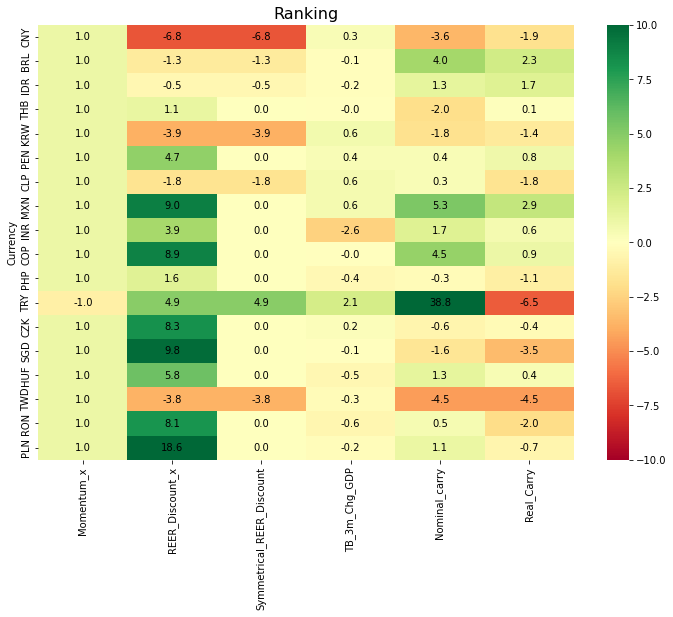

In [74]:

# Extract the data for the heatmap from the DataFrame
data = df[['Currency','Momentum_x', 'REER_Discount_x', 'Symmetrical_REER_Discount', 
           'TB_3m_Chg_GDP', 'Nominal_carry', 'Real_Carry']]

# Select the columns to multiply by 100 (excluding 'Currency' and 'Momentum_x')
columns_to_multiply = ['REER_Discount_x', 'Symmetrical_REER_Discount', 'TB_3m_Chg_GDP', 'Nominal_carry', 'Real_Carry']

# Multiply the selected columns by 100
data[columns_to_multiply] = data[columns_to_multiply] * 100 
           # Define the desired order from the image
order = ['CNY', 'BRL', 'IDR', 'THB', 'KRW', 'PEN', 'CLP', 'MXN', 'INR', 'COP', 'PHP', 'TRY', 'CZK', 'SGD', 'HUF', 'TWD', 'MYR', 'RON', 'PLN']

# Create a categorical column for 'Currency' with the desired order
data['Currency'] = pd.Categorical(data['Currency'], categories=order, ordered=True)
data = data.dropna()
# Sort the DataFrame based on the categorical 'Currency' column
data = data.sort_values('Currency').reset_index(drop=True)

data = data[['Currency','Momentum_x', 'REER_Discount_x', 'Symmetrical_REER_Discount', 
           'TB_3m_Chg_GDP', 'Nominal_carry', 'Real_Carry']]
data_dict = data.to_dict(orient='list')


# Add the 'Currency' column to the data dictionary

# Convert the data dictionary to a DataFrame
df_heatmap = pd.DataFrame(data_dict)

# Set 'Currency' as the index
df_heatmap.set_index('Currency', inplace=True)

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Assuming you have your DataFrame 'df' loaded

# ... (your data preparation code)

# Create the heatmap with adjusted color scale
plt.figure(figsize=(12, 8))
sns.heatmap(df_heatmap, annot=True, fmt=".1f", 
            cmap="RdYlGn",  # Reverse the Red-Yellow-Green colormap
            center=0, 
            vmin=-10,  # Set the minimum value for the color scale
            vmax=10,   # Set the maximum value for the color scale
            annot_kws={"color": "black"}) 
plt.title("Ranking", fontsize=16)
plt.show()

In [76]:
df[['Currency','Real_Carry']]

,Currency,Real_Carry
0,BRL,0.023390
1,CLP,-0.017968
2,CNY,-0.018585
3,COP,0.009479
4,CZK,-0.003639
5,HUF,0.003994
6,IDR,0.016956
7,INR,0.005599
8,KRW,-0.013532
9,MXN,0.028664


C:\Users\UT3P5T\AppData\Local\Temp\1/ipykernel_1752/3084671103.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[columns_to_multiply] = data[columns_to_multiply] * 100
C:\Users\UT3P5T\AppData\Local\Temp\1/ipykernel_1752/3084671103.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Currency'] = pd.Categorical(data['Currency'], categories=order, ordered=True)


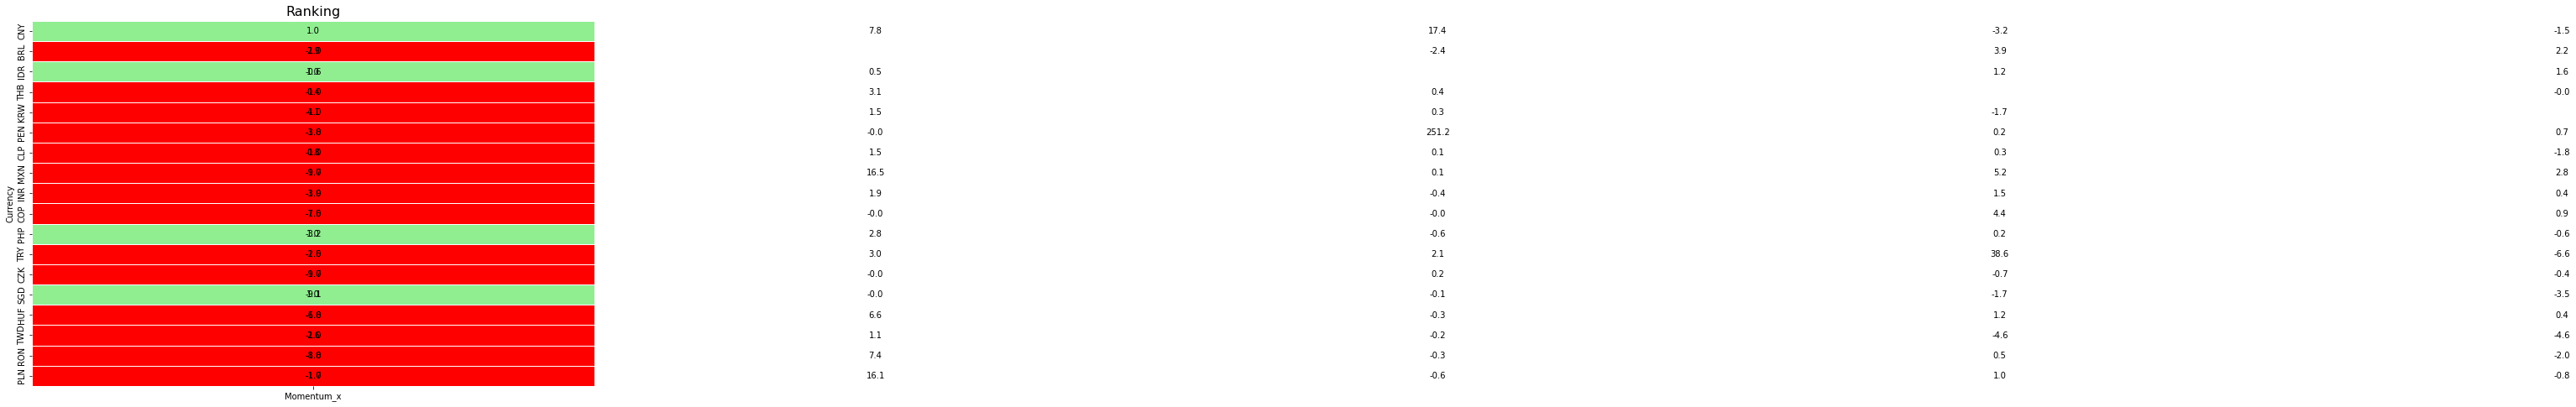

In [125]:

# Extract the data for the heatmap from the DataFrame
data = df[['Currency','Momentum_x', 'REER_Discount_x', 'Symmetrical_REER_Discount', 
           'TB_3m_Chg_GDP', 'Nominal_carry', 'Real_Carry']]

# Select the columns to multiply by 100 (excluding 'Currency' and 'Momentum_x')
columns_to_multiply = ['REER_Discount_x', 'Symmetrical_REER_Discount', 'TB_3m_Chg_GDP', 'Nominal_carry', 'Real_Carry']

# Multiply the selected columns by 100
data[columns_to_multiply] = data[columns_to_multiply] * 100 
           # Define the desired order from the image
order = ['CNY', 'BRL', 'IDR', 'THB', 'KRW', 'PEN', 'CLP', 'MXN', 'INR', 'COP', 'PHP', 'TRY', 'CZK', 'SGD', 'HUF', 'TWD', 'MYR', 'RON', 'PLN']

# Create a categorical column for 'Currency' with the desired order
data['Currency'] = pd.Categorical(data['Currency'], categories=order, ordered=True)
data = data.dropna()
# Sort the DataFrame based on the categorical 'Currency' column
data = data.sort_values('Currency').reset_index(drop=True)

data = data[['Currency','Momentum_x', 'REER_Discount_x', 'Symmetrical_REER_Discount', 
           'TB_3m_Chg_GDP', 'Nominal_carry', 'Real_Carry']]
data_dict = data.to_dict(orient='list')


# Add the 'Currency' column to the data dictionary

# Convert the data dictionary to a DataFrame
df_heatmap = pd.DataFrame(data_dict)

# Set 'Currency' as the index
df_heatmap.set_index('Currency', inplace=True)

# Create a custom colormap for Momentum
# Create a custom colormap for Momentum
cmap_momentum = sns.color_palette(['red', 'lightgreen'], as_cmap=True)

# Invert the data for REER_Discount_x and Symmetrical_REER_Discount
df_heatmap['REER_Discount_x'] = -df_heatmap['REER_Discount_x']
df_heatmap['Symmetrical_REER_Discount'] = -df_heatmap['Symmetrical_REER_Discount']

# Create the heatmap with adjusted color scales and custom colormap
plt.figure(figsize=(12, 8))

# Create a mask for Momentum column
mask_momentum = df_heatmap.columns != 'Momentum_x'

# Apply heatmap for all columns except Momentum
sns.heatmap(df_heatmap.loc[:, mask_momentum], annot=True, fmt=".1f", 
            cmap="RdYlGn", 
            center=0, 
            vmin=-10, 
            vmax=10, 
            annot_kws={"color": "black"},
            linewidths=.5,
            linecolor='white',
            cbar=False, 
            mask=np.equal(*np.indices(df_heatmap.loc[:, mask_momentum].shape))) 

# Apply custom colormap to 'Momentum_x' column
sns.heatmap(df_heatmap[['Momentum_x']], annot=True, fmt=".1f", 
            cmap=cmap_momentum, 
            center=0, 
            vmin=-1, 
            vmax=1, 
            annot_kws={"color": "black"},
            linewidths=.5, 
            linecolor='white',
            cbar=False) 

plt.title("Ranking", fontsize=16)
plt.show()

In [126]:
df['Symmetrical_REER_Discount']

0     0.000000
1    -0.015254
2    -0.077788
3     0.000000
4     0.000000
5    -0.065905
6    -0.004625
7    -0.019120
8    -0.015217
9    -0.165444
10    0.000000
11   -0.027987
12   -0.160658
13   -0.074286
14    0.000000
15    0.000000
16   -0.031021
17   -0.029722
18   -0.011368
Name: Symmetrical_REER_Discount, dtype: float64

In [ ]:
df['REER_Discount_x']

0     -2.801559
1     -1.998597
2     -7.352728
3      8.531717
4     10.164201
5      7.432568
6      0.857799
7      3.044271
8     -3.789987
9      7.394698
10     3.114332
11     2.931468
12    16.811006
13     8.230074
14    -6.353034
15     9.229731
16    -0.636027
17     1.717428
18    -2.407411
Name: REER_Discount_x, dtype: float64

In [136]:
import numpy as np

data = [-0.13, 0.57, 0.33, -0.03, 0.21, -0.47, -0.15, -1.83, 0.09, 1.17, 0.34, -0.51, 1.60, 2.04, 0.55, -0.06, 0.97, -0.29, -0.16, -0.28, 0.67, -1.15, -0.53, 0.21, -0.02]  
data_np = np.array(data)
data_np = data_np/100

standard_deviation = np.std(data_np)
standard_deviation

0.007924598664916729

In [ ]:
BRL	CLP	CNY	COP	CZK	HUF	IDR	MYR	MXN	PEN	PHP	PLN	RON	RUB	ZAR	THB	TRY	INR	SGD	TWD	KRW	UAH	EGP	EUR	JPY


In [144]:

currencies = ['BRL', 'CLP', 'CNY', 'COP', 'CZK', 'HUF', 'IDR', 'MYR', 'MXN', 'PEN', 'PHP', 'PLN', 'RON', 'RUB', 'ZAR', 'THB', 'TRY', 'INR', 'SGD', 'TWD', 'KRW', 'UAH', 'EGP', 'EUR', 'JPY']
data = [-0.13, 0.57, 0.33, -0.03, 0.21, -0.47, -0.15, 0.34, 1.17, -0.51, 1.60, 2.04, 0.55, -0.06, -0.28, 0.97, -0.29, -1.83, 0.67, -0.16, 0.09, -0.53, 0.21, -0.02, -1.15]

# Divide data by 100
data_divided = [x / 100 for x in data]

# Create the DataFrame
df = pd.DataFrame({'Currency': currencies, 'Value': data_divided})

print(df['Value'].std())

0.008088009643911164


In [119]:
criteria

['Symmetrical_REER_Discount', 'TB_3m_Chg_GDP', 'Real_Carry']

In [137]:
np.std(df['TB_3m_Chg_GDP'])

0.019752000196979026

In [127]:
 df[['TB_3m_Chg_GDP','Currency']]

,TB_3m_Chg_GDP,Currency
0,-0.001288,BRL
1,0.005663,CLP
2,0.003282,CNY
3,-0.000275,COP
4,0.002116,CZK
5,-0.004708,HUF
6,-0.001532,IDR
7,-0.025522,INR
8,0.006429,KRW
9,0.005979,MXN


In [112]:
df.columns

Index(['Currency', 'MOV_AVG_5D', 'MOV_AVG_20D', 'Momentum_x', '3M Implied Vol',
       'CPI', 'REER_x', 'REER_5Y_avg_x', 'REER_y', 'REER_5Y_avg_y', 'spot_adj',
       'infla_adj', 'proxy', 'REER_Discount_x', 'REER_Discount_y',
       'Momentum_y', 'Conditional_REER_Discount', 'Symmetrical_REER_Discount',
       'GDP', 'TB_3m_Chg_GDP', 'SPOT_MID', 'FWD_SCALE', 'FPA3M_MID',
       'FPA1M_MID', 'security', 'TB', 'TB_3m_Chg', 'DayCount', 'Multiplier',
       '3m_imp_yield', 'calculated_value', 'CPI YOY', 'Real_Carry',
       'Nominal_carry', 'zscore_RN_part1', 'zscore_RN_part2',
       'zscore_RN_part3', 'zscore_CN_part1', 'zscore_CN_part2',
       'zscore_CN_part3', 'zscore_SN_part1', 'zscore_SN_part2',
       'zscore_SN_part3', 'zscore_RR_part1', 'zscore_RR_part2',
       'zscore_RR_part3', 'zscore_CR_part1', 'zscore_CR_part2',
       'zscore_CR_part3', 'zscore_SR_part1', 'zscore_SR_part2',
       'zscore_SR_part3'],
      dtype='object')

In [84]:
rub_index = df[df['Currency'] == 'RUB'].index
df = df.drop(index=rub_index)

In [92]:
df['TB_3m_Chg_GDP'].std()

0.006178672986590452

In [85]:
### ZSCORE GOOD ##########
rub_index = df[df['Currency'] == 'RUB'].index
df = df.drop(index=rub_index)
models = {
    "RN": ["REER_Discount_x", "TB_3m_Chg_GDP", "Nominal_carry"],
    "CN": ["Conditional_REER_Discount", "TB_3m_Chg_GDP", "Nominal_carry"],
    "SN": ["Symmetrical_REER_Discount", "TB_3m_Chg_GDP", "Nominal_carry"],
    "RR": ["REER_Discount_x", "TB_3m_Chg_GDP", "Real_Carry"],
    "CR": ["Conditional_REER_Discount", "TB_3m_Chg_GDP", "Real_Carry"],
    "SR": ["Symmetrical_REER_Discount", "TB_3m_Chg_GDP", "Real_Carry"],
}

# Loop through each model and calculate the Z-score
for model_name, criteria in models.items():
    # Calculate the weighted average of the criteria for each currency
    df[f'zscore_{model_name}_part1'] = df.apply(
        lambda row: (-row[criteria[0]] / df[criteria[0]].std() 
                     if criteria[0] == "Symmetrical_REER_Discount" or "Conditionnal_REER_Discount"
                     else row[criteria[0]] / df[criteria[0]].std()),
        axis=1
    )
    df[f'zscore_{model_name}_part2'] = df.apply(
        lambda row: (row[criteria[1]] / df[criteria[1]].std()),
        axis=1
    )
    df[f'zscore_{model_name}_part3'] = df.apply(
        lambda row: (row[criteria[2]] / df[criteria[2]].std()),
        axis=1
    )

In [86]:
### ZSCORE SUM PARTS GOOD ####
for model_name, criteria in models.items():
    # ... (previous code for calculating part1, part2, part3) ...

    # Calculate the sum of the parts
    df[f'zscore_{model_name}'] = (
        (df[f'zscore_{model_name}_part1'] + 
        df[f'zscore_{model_name}_part2'] + 
        df[f'zscore_{model_name}_part3'])/3
    )

In [87]:
df[['REER_Discount_x','Conditional_REER_Discount','Currency']]

,REER_Discount_x,Conditional_REER_Discount,Currency
0,-0.017439,-0.017439,BRL
1,-0.025945,-0.025945,CLP
2,-0.061949,-0.061949,CNY
3,0.085448,0.000000,COP
4,0.068603,0.000000,CZK
5,0.034436,0.000000,HUF
6,-0.020559,-0.020559,IDR
7,0.026584,0.000000,INR
8,-0.033199,-0.033199,KRW
9,0.086152,0.000000,MXN


In [188]:
df[['TB_3m_Chg_GDP', 'Currency']]

,TB_3m_Chg_GDP,Currency
0,-0.001380,BRL
1,0.005663,CLP
2,0.003282,CNY
3,-0.000275,COP
4,0.002116,CZK
5,-0.005179,HUF
6,-0.001532,IDR
7,-0.002873,INR
8,0.004379,KRW
9,-0.002292,MXN


In [91]:
df[['zscore_CR','zscore_CR_part1','zscore_CR_part2', 'zscore_CR_part3','Currency']]

,zscore_CR,zscore_CR_part1,zscore_CR_part2,zscore_CR_part3,Currency
0,0.267185,1.015211,-0.223374,0.009718,BRL
1,0.806336,1.510354,0.916480,-0.007828,CLP
2,1.376936,3.606306,0.531160,-0.006659,CNY
3,-0.013652,-0.000000,-0.044520,0.003564,COP
4,0.113226,-0.000000,0.342422,-0.002743,CZK
5,-0.278928,-0.000000,-0.838234,0.001451,HUF
6,0.319431,1.196796,-0.247875,0.009371,IDR
7,-0.156722,-0.000000,-0.465036,-0.005131,INR
8,0.881916,1.932619,0.708698,0.004431,KRW
9,-0.127000,-0.000000,-0.370942,-0.010059,MXN


In [114]:
############# Z SCORE GOOD ####################################
# Define the models and their corresponding criteria
models = {
    "RN": ["REER_Discount_x", "TB_3m_Chg_GDP", "Nominal_carry"],
    "CN": ["Conditional_REER_Discount", "TB_3m_Chg_GDP", "Nominal_carry"],
    "SN": ["Symmetrical_REER_Discount", "TB_3m_Chg_GDP", "Nominal_carry"],
    "RR": ["REER_Discount_x", "TB_3m_Chg_GDP", "Real_Carry"],
    "CR": ["Conditional_REER_Discount", "TB_3m_Chg_GDP", "Real_Carry"],
    "SR": ["Symmetrical_REER_Discount", "TB_3m_Chg_GDP", "Real_Carry"],
}

# Loop through each model and calculate the Z-score
for model_name, criteria in models.items():
    # Calculate the weighted average of the criteria for each currency
    df[f'zscore_{model_name}'] = df.apply(
        lambda row: (1/3) * (
            (row[criteria[0]] / df[criteria[0]].std()) +
            (row[criteria[1]] / df[criteria[1]].std()) +
            (row[criteria[2]] / df[criteria[2]].std())
        ),
        axis=1
    )

# Print the updated DataFrame with Z-score columns
print(df)

   Currency  MOV_AVG_5D  MOV_AVG_20D  Momentum_x  3M Implied Vol       CPI  \
0       BRL      5.4806       5.5634           1         14.5230  0.380000   
1       CLP    920.0400     925.8400           1         13.0400  0.700000   
2       CNY      7.0455       7.0926           1          6.0550  0.500000   
3       COP   4164.4800    4189.5800           1         13.9725  0.200000   
4       CZK     22.5172      22.6139           1          7.5400  0.700000   
5       HUF    353.6900     355.5700           1          9.7850  0.700000   
6       IDR  15175.0000   15363.0000           1          7.7725 -0.180000   
7       INR     83.6190      83.8509           1          2.5125  3.875135   
8       KRW   1333.2600    1336.0100           1          8.8950  0.300000   
9       MXN     19.4264      19.6136           1         14.9670  1.050000   
10      MYR      4.1801       4.2904           1          6.9650  0.100000   
11      PEN      3.7596       3.7729           1          4.6350

In [117]:
df[['zscore_SR','Currency']]


,zscore_SR,Currency
0,0.109162,BRL
1,-0.423050,CLP
2,-1.210113,CNY
3,0.127404,COP
4,-0.015840,CZK
5,-0.021862,HUF
6,0.138509,IDR
7,-0.341889,INR
8,-0.655441,KRW
9,0.497285,MXN


In [ ]:
df.columns

Index(['Currency', 'MOV_AVG_5D', 'MOV_AVG_20D', 'Momentum_x', '3M Implied Vol',
       'CPI', 'REER_x', 'REER_5Y_avg_x', 'REER_y', 'REER_5Y_avg_y', 'spot_adj',
       'infla_adj', 'proxy', 'REER_Discount_x', 'REER_Discount_y',
       'Momentum_y', 'Conditional_REER_Discount', 'Symmetrical_REER_Discount',
       'GDP', 'TB_3m_Chg_GDP', 'SPOT_MID', 'FWD_SCALE', 'FPA3M_MID',
       'FPA1M_MID', 'security', 'TB', 'TB_3m_Chg', 'DayCount', 'Multiplier',
       '3m_imp_yield', 'calculated_value', 'CPI YOY', 'Real_Carry',
       'Nominal_carry', 'zscore_RN', 'zscore_CN', 'zscore_SN', 'zscore_RR',
       'zscore_CR', 'zscore_SR', 'rank_RN', 'conviction_RN_Agn',
       'conviction_RN_Awa', 'rank_CN', 'conviction_CN_Agn',
       'conviction_CN_Awa', 'rank_SN', 'conviction_SN_Agn',
       'conviction_SN_Awa', 'rank_RR', 'conviction_RR_Agn',
       'conviction_RR_Awa', 'rank_CR', 'conviction_CR_Agn',
       'conviction_CR_Awa', 'rank_SR', 'conviction_SR_Agn',
       'conviction_SR_Awa'],
      dtyp

In [218]:

# Define the conviction score mapping based on sorted Z-score ranks
models = ["RN", "CN", "SN", "RR", "CR", "SR"]

conviction_mapping = {
    0: 3, 1: 3,  # Top 2
    2: 2, 3: 2, 4: 2,  # Next 3
    5: 1, 6: 1, 7: 1,  # Next 3
    8: 0, 9: 0, 10: 0, 11: 0,  # Next 4
    12: -1, 13: -1, 14: -1,  # Next 3
    15: -2, 16: -2, 17: -2,  # Next 3
    18: -3, 19: -3  # Last 2
}

# Loop through each model and calculate conviction scores
for model_name in models:
    # Rank currencies based on Z-scores for each model
    df[f'rank_{model_name}'] = df[f'zscore_{model_name}'].rank(ascending=False)

    # Sort the DataFrame by rank for the current model
    df_sorted = df.sort_values(by=f'rank_{model_name}')

    # Assign conviction scores based on the sorted rank
    df_sorted[f'conviction_{model_name}_Agn'] = df_sorted[f'rank_{model_name}'].apply(
        lambda rank: conviction_mapping.get(rank - 1, None) 
    )

    # Merge the conviction scores back into the original DataFrame
    df = pd.merge(df, df_sorted[[f'conviction_{model_name}_Agn']], left_index=True, right_index=True, how='left')

# Print or use the updated DataFrame 'df'
print(df)

   Currency  MOV_AVG_5D  MOV_AVG_20D  Momentum_x  3M Implied Vol       CPI  \
0       BRL      5.4413       5.5168           1         14.4580 -0.020000   
1       CLP    903.0900     924.2500           1         13.0100  0.300000   
2       CNY      7.0213       7.0772           1          6.5450  0.400000   
3       COP   4189.8000    4195.9300           1         13.9675  0.000000   
4       CZK     22.6900      22.6249          -1          7.9800  0.300000   
5       HUF    357.7200     356.1600          -1         10.1975  0.000000   
6       IDR  15179.0000   15291.0000           1          7.7450 -0.030000   
7       INR     83.7140      83.8179           1          2.5625  3.875135   
8       KRW   1320.2100    1332.8400           1          9.5350  0.400000   
9       MXN     19.6151      19.5606          -1         15.9030  0.010000   
10      MYR      4.1456       4.2416           1          6.8900  0.100000   
11      PEN      3.7147       3.7597           1          6.7500

In [251]:
df_backup[['conviction_CR_Agn_y',"Currency"]].sort_values(by='conviction_CR_Agn_y')

KeyError: "['conviction_CR_Agn_y'] not in index"

In [252]:
df

,Currency,MOV_AVG_5D,MOV_AVG_20D,Momentum,3M Implied Vol
0,BRL,5.4478,5.5116,1,14.5320
1,CLP,906.8400,924.3400,1,13.0300
2,CNY,7.0213,7.0772,1,6.7100
3,COP,4200.1600,4198.5700,-1,13.9875
4,CZK,22.7835,22.6464,-1,8.0400
5,HUF,359.5600,356.6500,-1,10.4575
6,IDR,15230.0000,15288.0000,1,7.8600
7,INR,83.7870,83.8180,1,2.5525
8,KRW,1320.2100,1332.8400,1,9.6650
9,MXN,19.5933,19.5434,-1,15.9800


In [224]:
df[['conviction_CR_Agn_y',"Currency"]].sort_values(by='conviction_CR_Agn_y')

,conviction_CR_Agn_y,Currency
14,-3,RON
10,-3,MYR
18,-2,TRY
13,-2,PLN
12,-2,PHP
5,-1,HUF
16,-1,SGD
19,-1,TWD
17,0,THB
3,0,COP


In [15]:
import pandas as pd 
data = {
    'conviction_CR_Agn_y': [-3, -3, -2, -2, -2, -1, -1, -1, 0, 0, 0, 0, 1, 1, 1, 2, 2, 2, 3, 3],
    'Currency': ['RON', 'MYR', 'TRY', 'PLN', 'PHP', 'HUF', 'SGD', 'TWD', 'THB', 'COP', 'CZK', 'INR', 'MXN', 'ZAR', 'CLP', 'KRW', 'IDR', 'BRL', 'CNY', 'PEN']
}
data = pd.DataFrame(data)
data = data.sort_values(by='conviction_CR_Agn_y', ascending=False)

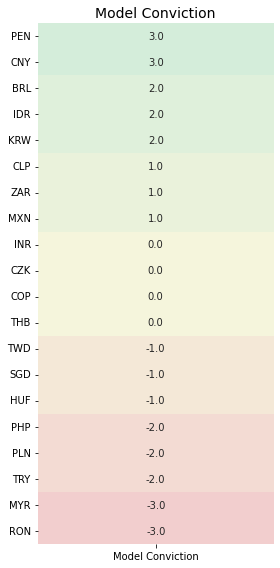

In [16]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
# Create a custom colormap from red to green
cmap = LinearSegmentedColormap.from_list(
    "rg", ["#F2CECE", "#F5F5DC", "#D4EDDA"], N=256
)

# Plot the table with color gradient and beige background
fig, ax = plt.subplots(figsize=(4, 8))

sns.heatmap(data[['conviction_CR_Agn_y']], annot=True, fmt=".1f", cmap=cmap, 
            center=0, vmin=-3, vmax=3, ax=ax, cbar=False,
            yticklabels=data['Currency'])

# Set beige background
ax.set_facecolor('#F5F5DC') 

ax.set_xticklabels(['Model Conviction'], rotation=0)
plt.title('Model Conviction', fontsize=14)
plt.tight_layout()
plt.show()

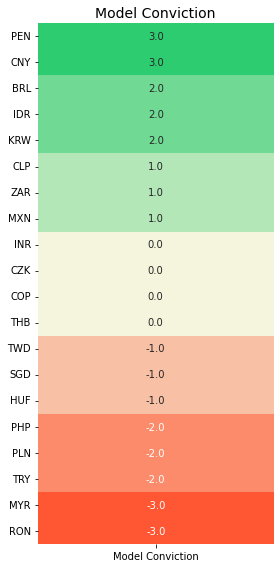

In [17]:
# Create a custom colormap from flashier red to flashier green
cmap = LinearSegmentedColormap.from_list(
    "rg", ["#FF5733", "#F5F5DC", "#2ECC71"], N=256
)

# Plot the table with color gradient and beige background
fig, ax = plt.subplots(figsize=(4, 8))

sns.heatmap(data[['conviction_CR_Agn_y']], annot=True, fmt=".1f", cmap=cmap, 
            center=0, vmin=-3, vmax=3, ax=ax, cbar=False,
            yticklabels=data['Currency'])

# Set beige background
ax.set_facecolor('#F5F5DC') 

ax.set_xticklabels(['Model Conviction'], rotation=0)
plt.title('Model Conviction', fontsize=14)
plt.tight_layout()
plt.show()

In [10]:
!pip install pandas-style


Looking in indexes: https://repository.saas.cagip.group.gca/artifactory/api/pypi/pypi-remote/simple

ERROR: Could not find a version that satisfies the requirement pandas-style (from versions: none)
ERROR: No matching distribution found for pandas-style


In [11]:
from pandas_style import Styler

# Create a Styler object
styler = Styler(data)

# Apply background gradient based on 'conviction_CR_Agn_y'
styler.background_gradient(cmap='RdYlGn', subset=['conviction_CR_Agn_y']) 

# Display the styled DataFrame
print(styler)

ModuleNotFoundError: No module named 'pandas_style'

In [207]:
#######    CONVICTION GOOD #######################################
# Define the models
models = ["RN", "CN", "SN", "RR", "CR", "SR"]

# Loop through each model and calculate conviction scores
for model_name in models:
    # Rank currencies based on Z-scores for each model
    df[f'rank_{model_name}'] = df[f'zscore_{model_name}'].rank(ascending=False)
    #print(df[f'rank_{model_name}'] )
    # Calculate Agnostic (Agn) conviction scores
    df[f'conviction_{model_name}_Agn'] = df.apply(
        lambda row: 3 - (np.floor(row[f'rank_{model_name}'] / 3)) if row[f'rank_{model_name}'] <= 8 
                   else 0 if 9 <= row[f'rank_{model_name}'] <= 12
                   else -3 + (np.floor(row[f'rank_{model_name}'] / 3)) if row[f'rank_{model_name}'] > 12
                   else None,  # Handle potential errors (e.g., NaN ranks)
        axis=1
    )

    # Calculate Agnostic (Agn) conviction scores
    df[f'conviction_{model_name}_Awa'] = df.apply(
        lambda row: max(-3, min(3, (
             (np.ceil(row[f'zscore_{model_name}'] * 2) / 2) if row[f'rank_{model_name}'] <= 8 
            else 0 if 9 <= row[f'rank_{model_name}'] <= 12
            else  (np.floor(row[f'zscore_{model_name}'] * 2) / 2) if row[f'rank_{model_name}'] > 12
            else None
        ))),
        axis=1
    )
    print(df[f'conviction_{model_name}_Awa'])

0     0.5
1     0.5
2     0.5
3    -0.5
4    -0.5
5    -0.5
6     0.5
7     0.0
8     0.5
9    -1.0
10   -1.5
11    0.5
12    0.0
13   -1.5
14   -1.0
16   -1.0
17    0.0
18    2.0
19    0.0
20    0.5
Name: conviction_RN_Awa, dtype: float64
0     0.5
1     1.0
2     1.5
3     0.0
4     0.0
5    -0.5
6     0.0
7    -0.5
8     1.0
9     0.0
10   -1.5
11    1.0
12   -0.5
13   -0.5
14   -0.5
16   -0.5
17   -0.5
18    2.0
19    0.5
20    0.5
Name: conviction_CN_Awa, dtype: float64
0     0.5
1     0.5
2     0.5
3     0.5
4    -0.5
5    -0.5
6     0.0
7     0.0
8     0.5
9    -1.0
10   -1.5
11    1.0
12   -0.5
13   -1.5
14   -0.5
16   -0.5
17    0.0
18    2.0
19    0.0
20    0.5
Name: conviction_SN_Awa, dtype: float64
0     0.5
1     0.5
2     0.5
3    -0.5
4     0.0
5    -0.5
6     0.5
7     0.0
8     0.5
9     0.0
10   -1.5
11    0.5
12    0.0
13   -1.5
14   -1.5
16   -1.0
17   -0.0
18   -1.0
19   -1.0
20    0.5
Name: conviction_RR_Awa, dtype: float64
0     0.5
1     0.5
2     1.5
3     0.0


# faire code pour ranking metrics jour X 

In [ ]:
df[['conviction_CR_Agn_x','Currency']].sort_values(by='conviction_CR_Agn_x')

In [220]:
df[['conviction_CR_Agn_x','Currency']].sort_values(by='conviction_CR_Agn_x')

,conviction_CR_Agn_x,Currency
17,0.0,THB
3,0.0,COP
4,0.0,CZK
7,0.0,INR
9,1.0,MXN
19,1.0,TWD
20,1.0,ZAR
5,1.0,HUF
1,1.0,CLP
8,2.0,KRW


In [213]:
# Sort the DataFrame by the 'conviction_CR_Awa' column
df_sorted = df.sort_values(by='conviction_CR_Awa')

print(df_sorted)

   Currency  MOV_AVG_5D  MOV_AVG_20D  Momentum_x  3M Implied Vol       CPI  \
10      MYR      4.1456       4.2416           1          6.8900  0.100000   
18      TRY     34.1890      34.0746          -1         13.5150  2.470000   
14      RON      4.4760       4.4792           1          6.5525  0.230000   
5       HUF    357.7200     356.1600          -1         10.1975  0.000000   
16      SGD      1.2860       1.2940           1          5.1475  0.700000   
19      TWD     31.7770      31.9770           1          8.2950  0.400000   
13      PLN      3.8534       3.8520          -1          9.4400  0.100000   
12      PHP     56.0870      56.0140          -1          6.2700  0.100000   
17      THB     32.4960      33.1300           1          9.9775  0.070000   
3       COP   4189.8000    4195.9300           1         13.9675  0.000000   
4       CZK     22.6900      22.6249          -1          7.9800  0.300000   
7       INR     83.7140      83.8179           1          2.5625

In [146]:
df.columns

Index(['Currency', 'MOV_AVG_5D', 'MOV_AVG_20D', 'Momentum_x', '3M Implied Vol',
       'CPI', 'REER_x', 'REER_5Y_avg_x', 'REER_y', 'REER_5Y_avg_y', 'spot_adj',
       'infla_adj', 'proxy', 'REER_Discount_x', 'REER_Discount_y',
       'Momentum_y', 'Conditional_REER_Discount', 'Symmetrical_REER_Discount',
       'GDP', 'security_x', 'TB_x', 'TB_3m_Chg_x', 'SPOT_MID', 'FWD_SCALE',
       'FPA3M_MID', 'FPA1M_MID', 'security_y', 'TB_y', 'TB_3m_Chg_y',
       'DayCount', 'Multiplier', '3m_imp_yield', 'CPI YOY', 'Real_Carry',
       'Nominal_carry', 'TB_3m_Chg_GDP', 'zscore_RN', 'zscore_CN', 'zscore_SN',
       'zscore_RR', 'zscore_CR', 'zscore_SR', 'rank_RN', 'conviction_RN_Agn',
       'rank_CN', 'conviction_CN_Agn', 'rank_SN', 'conviction_SN_Agn',
       'rank_RR', 'conviction_RR_Agn', 'rank_CR', 'conviction_CR_Agn',
       'rank_SR', 'conviction_SR_Agn', 'conviction_RN_Awa',
       'conviction_CN_Awa', 'conviction_SN_Awa', 'conviction_RR_Awa',
       'conviction_CR_Awa', 'conviction_SR_A

In [208]:
################ SIZE GOOD #################
# Define models and constants
models = ["RN", "CN", "SN", "RR", "CR", "SR"]
concentration_limit = 0.05
medium_conviction = 2

# Loop through each model and calculate position sizes
for model_name in models:
    for method in ["Agn", "Awa"]:
        model = f"{model_name}-{method}"
        conviction_col = f"conviction_{model_name}_{method}"
        standard_size = 0.03 if method == "Agn" else 0.035

        df[f'size_{model}'] = df.apply(
            lambda row: max(
                -concentration_limit,
                min(
                    (1 / (20 * df['3M Implied Vol'].sum())) * row['3M Implied Vol'] * row[conviction_col] * standard_size,
                    concentration_limit
                )
            )
            if row[conviction_col] == medium_conviction
            else max(
                -concentration_limit,
                min(
                    (1 / df['3M Implied Vol'].sum()) * row['3M Implied Vol'] * row[conviction_col] * standard_size,
                    concentration_limit
                )
            ),
            axis=1
        )

# Print the updated DataFrame with position size columns


In [210]:
df.columns

Index(['Currency', 'MOV_AVG_5D', 'MOV_AVG_20D', 'Momentum_x', '3M Implied Vol',
       'CPI', 'REER_x', 'REER_5Y_avg_x', 'REER_y', 'REER_5Y_avg_y', 'spot_adj',
       'infla_adj', 'proxy', 'REER_Discount_x', 'REER_Discount_y',
       'Momentum_y', 'Conditional_REER_Discount', 'Symmetrical_REER_Discount',
       'GDP', 'TB_3m_Chg_GDP', 'SPOT_MID', 'FWD_SCALE', 'FPA3M_MID',
       'FPA1M_MID', 'security', 'TB', 'TB_3m_Chg', 'DayCount', 'Multiplier',
       '3m_imp_yield', 'calculated_value', 'CPI YOY', 'Real_Carry',
       'Nominal_carry', 'zscore_RN_part1', 'zscore_RN_part2',
       'zscore_RN_part3', 'zscore_CN_part1', 'zscore_CN_part2',
       'zscore_CN_part3', 'zscore_SN_part1', 'zscore_SN_part2',
       'zscore_SN_part3', 'zscore_RR_part1', 'zscore_RR_part2',
       'zscore_RR_part3', 'zscore_CR_part1', 'zscore_CR_part2',
       'zscore_CR_part3', 'zscore_SR_part1', 'zscore_SR_part2',
       'zscore_SR_part3', 'zscore_RN', 'zscore_CN', 'zscore_SN', 'zscore_RR',
       'zscore_CR', 

In [209]:
df_backup = df

In [ ]:
df_backup.columns

Index(['Currency', 'MOV_AVG_5D', 'MOV_AVG_20D', 'Momentum_x', '3M Implied Vol',
       'CPI', 'REER_x', 'REER_5Y_avg_x', 'REER_y', 'REER_5Y_avg_y', 'spot_adj',
       'infla_adj', 'proxy', 'REER_Discount_x', 'REER_Discount_y',
       'Momentum_y', 'Conditional_REER_Discount', 'Symmetrical_REER_Discount',
       'GDP', 'TB_3m_Chg_GDP', 'SPOT_MID', 'FWD_SCALE', 'FPA3M_MID',
       'FPA1M_MID', 'security', 'TB', 'TB_3m_Chg', 'DayCount', 'Multiplier',
       '3m_imp_yield', 'CPI YOY', 'Real_Carry', 'Nominal_carry', 'zscore_RN',
       'zscore_CN', 'zscore_SN', 'zscore_RR', 'zscore_CR', 'zscore_SR',
       'rank_RN', 'conviction_RN_Agn', 'conviction_RN_Awa', 'rank_CN',
       'conviction_CN_Agn', 'conviction_CN_Awa', 'rank_SN',
       'conviction_SN_Agn', 'conviction_SN_Awa', 'rank_RR',
       'conviction_RR_Agn', 'conviction_RR_Awa', 'rank_CR',
       'conviction_CR_Agn', 'conviction_CR_Awa', 'rank_SR',
       'conviction_SR_Agn', 'conviction_SR_Awa', 'size_RN-Agn', 'size_RN-Awa',
       '

# From here, we make a break from the white paper and try to finish replicating all the rows of the sheet Today 

In [ ]:
1/0.7668

1.3041210224308815

In [ ]:
merged8.columns 

Index(['Currency', 'MOV_AVG_5D', 'MOV_AVG_20D', 'Momentum_x', '3M Implied Vol',
       'CPI', 'REER_x', 'REER_5Y_avg_x', 'REER_y', 'REER_5Y_avg_y', 'spot_adj',
       'infla_adj', 'proxy', 'REER_Discount_x', 'REER_Discount_y',
       'Momentum_y', 'Conditional_REER_Discount', 'Symmetrical_REER_Discount',
       'GDP', 'TB_3m_Chg_GDP', 'SPOT_MID', 'FWD_SCALE', 'FPA3M_MID',
       'FPA1M_MID', 'security', 'TB', 'TB_3m_Chg'],
      dtype='object')

In [ ]:
merged8[['3M Implied Vol']]

,3M Implied Vol
0,14.5420
1,12.9800
2,5.7050
3,14.2975
4,7.4500
5,9.6650
6,7.8850
7,2.3525
8,8.9000
9,15.8980


In [ ]:
BRL	CLP	CNY	COP	CZK	HUF	IDR	MYR	MXN	PEN	PHP	PLN	RON	RUB	ZAR	THB	TRY	INR	SGD	TWD	KRW	UAH	EGP	EUR	JPY
0	0	0	0	0	0	1	-1	0	0	0	0	0	0	0	-1	0	0	0	1	0	0	1	0	0


In [ ]:
merged8[['3M Implied Vol']]


,3M Implied Vol
0,14.5420
1,12.9800
2,5.7050
3,14.2975
4,7.4500
5,9.6650
6,7.8850
7,2.3525
8,8.9000
9,15.8980


# COMPUTE ANALYST SIZE LIKE IN SHEET TODAY 

In [ ]:
# Select rows in analyst_conviction where currencies are also in Vol

analyst_conviction = pd.DataFrame({
    'Currency': ['BRL', 'CLP', 'CNY', 'COP', 'CZK', 'HUF', 'IDR', 'MYR', 'MXN', 'PEN',
                'PHP', 'PLN', 'RON', 'RUB', 'ZAR', 'THB', 'TRY', 'INR', 'SGD', 'TWD',
                'KRW', 'UAH', 'EGP', 'EUR', 'JPY'],
    'Conviction': [0, 0, 0, 0, 0,0, 1, -1, 0, 0, 0, 0, 0, 0, 0, -1, 0, 0, 0, 1, 0, 0, 1, 0, 0]
})
analyst_conviction = analyst_conviction[analyst_conviction['Currency'].isin(Vol['Currency'])]

In [ ]:
analyst_conviction

,Currency,Conviction
0,BRL,0
1,CLP,0
2,CNY,0
3,COP,0
4,CZK,0
5,HUF,0
6,IDR,1
7,MYR,-1
8,MXN,0
9,PEN,0


In [ ]:
# Analyst convictions DataFrame
Vol = merged8[['3M Implied Vol', 'Currency']]
# Calculate average 3M implied vol
avg_implied_vol = Vol['3M Implied Vol'].mean()

default = 0.03  # 3%
concentration = 0.05  # 5%

# Merge analyst conviction with Vol DataFrame

# Get the common currencies between Vol and analyst_conviction
# Get common currencies
# Get common currencies

# Select rows in analyst_conviction with common currencies

# Select rows in Vol with common currencies

# Now merge the DataFrames on 'Currency'
Vol = Vol.merge(analyst_conviction, on='Currency')
# Calculate Analyst Size
Vol['Analyst_Size'] = Vol.apply(lambda row: max(min((avg_implied_vol / row['3M Implied Vol']) * row['Conviction'] * default / 2, concentration), -concentration), axis=1)

Vol

,3M Implied Vol,Currency,Conviction,Analyst_Size
0,14.5420,BRL,0,0.000000
1,12.9800,CLP,0,0.000000
2,5.7050,CNY,0,0.000000
3,14.2975,COP,0,0.000000
4,7.4500,CZK,0,0.000000
5,9.6650,HUF,0,0.000000
6,7.8850,IDR,1,0.018838
7,2.3525,INR,0,0.000000
8,8.9000,KRW,0,0.000000
9,15.8980,MXN,0,0.000000


# Plotting analyst sizes 

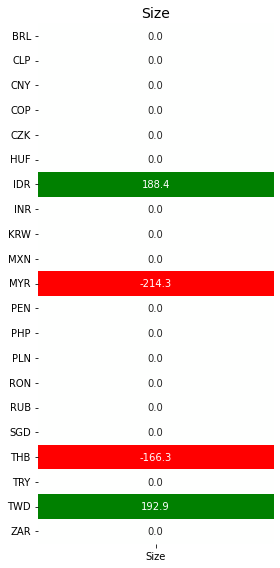

In [ ]:
from matplotlib.colors import LinearSegmentedColormap

# ... (Assuming you have the Vol DataFrame with 'Analyst_Size' column)

# Convert Analyst_Size to percentage
Vol['Analyst_Size'] = Vol['Analyst_Size'] * 100

# Create a custom colormap from red to green
cmap = LinearSegmentedColormap.from_list("rg", ["red", "white", "green"], N=256)

# Plot the table with color gradient
fig, ax = plt.subplots(figsize=(4, 8))  # Adjust figsize for a vertical table

# Use the custom colormap for the Analyst_Size column
sns.heatmap(Vol[['Analyst_Size']], annot=True, fmt=".1f", cmap=cmap, 
            center=0, vmin=-2, vmax=2, ax=ax, cbar=False,
            yticklabels=Vol['Currency'])

ax.set_xticklabels(['Size'], rotation=0)
plt.title('Size', fontsize=14)
plt.tight_layout()
plt.show()

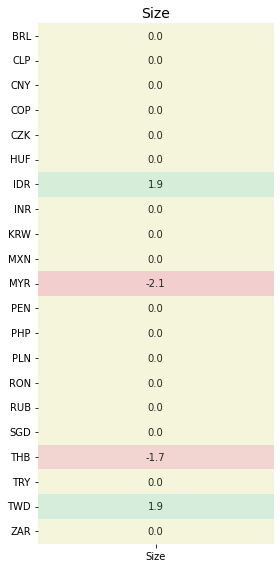

In [ ]:

# Convert Analyst_Size to percentage
Vol['Analyst_Size'] = Vol['Analyst_Size'] * 100

# Create a custom colormap from muted red to muted green
cmap = LinearSegmentedColormap.from_list(
    "rg", ["#F2CECE", "#F5F5DC", "#D4EDDA"], N=256
)

# Plot the table with color gradient and beige background
fig, ax = plt.subplots(figsize=(4, 8)) 

sns.heatmap(Vol[['Analyst_Size']], annot=True, fmt=".1f", cmap=cmap, 
            center=0, vmin=-2, vmax=2, ax=ax, cbar=False,
            yticklabels=Vol['Currency'])

# Set beige background
ax.set_facecolor('#F5F5DC') 

ax.set_xticklabels(['Size'], rotation=0)
plt.title('Size', fontsize=14)
plt.tight_layout()
plt.show()

# Zscores from fiche Today, Annualzed STDV = Tracking error in excel 
# Compute the beta 
# Compute Carry contribution 
# Re compute model conviction 
# plot implied volatility 
# Compute Size from fiche today 


In [150]:
data_prices

,BRL,CLP,CNY,COP,CZK,HUF,IDR,MYR,MXN,PEN,...,PLN,RON,RUB,ZAR,THB,TRY,INR,SGD,TWD,KRW
2019-09-19,4.16748,716.110,7.0963,3384.750,23.45675,301.151,14112.0,4.1898,19.45535,3.35515,...,3.93307,4.29755,64.01375,14.81915,30.5348,5.71871,71.39251,1.37874,30.9808,1195.26
2019-09-20,4.14755,717.530,7.0916,3416.201,23.47540,302.993,14114.0,4.1755,19.44697,3.35900,...,3.97060,4.31173,63.98695,14.93497,30.4840,5.74302,71.18251,1.37661,30.9430,1194.13
2019-09-23,4.16550,722.430,7.1185,3436.995,23.54215,304.820,14073.3,4.1810,19.48028,3.35533,...,3.99443,4.32040,63.83738,14.90125,30.4748,5.71770,70.76850,1.37801,31.0140,1195.05
2019-09-24,4.16500,724.018,7.1165,3435.245,23.46250,302.845,14124.6,4.1815,19.44595,3.34180,...,3.97359,4.31083,63.97355,14.86738,30.5468,5.69785,70.97091,1.37576,31.0100,1195.52
2019-09-25,4.14795,727.658,7.1317,3431.525,23.54500,305.378,14146.6,4.1895,19.56560,3.35085,...,4.00525,4.33768,64.19350,14.98890,30.6065,5.66965,71.02151,1.37874,31.0382,1199.81
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-09-13,5.56585,925.380,7.0955,4184.617,22.69570,356.457,15412.0,4.3020,19.20627,3.77750,...,3.86535,4.49120,90.13609,17.72017,33.2703,33.91460,83.82626,1.29760,31.9928,1329.93
2024-09-16,5.51105,922.495,NaN,4233.900,22.59475,354.210,15375.0,NaN,19.22855,3.77915,...,3.84078,4.46870,91.37505,17.61923,33.2540,34.01025,83.84526,1.29533,31.8785,1321.84
2024-09-17,5.48345,929.815,NaN,4211.660,22.58685,354.992,15350.0,4.2580,19.10115,3.75450,...,3.84582,4.47580,91.57170,17.61930,33.3858,34.08862,83.78301,1.29701,NaN,1326.06
2024-09-18,5.46075,931.850,7.0780,4182.070,22.54718,354.705,15307.0,4.2440,19.28677,3.75147,...,3.84135,4.47447,92.78364,17.54545,33.3606,34.05774,83.64001,1.29515,31.9870,1324.33


In [ ]:
##########################################################

# zscore excel today: zscore_xl 

##########################################################
##########################################################
##########################################################
# EX ANTE TRACKING ERROR from sheet 'today'  

# we have the data prices 
# Select the data range from 'Daily Rt'
daily_rt_data = data_prices.iloc[-507:,:]#Spot data of currencies 

daily_rt = data_prices.pct_change().dropna()

# Convert weights to a NumPy array
weights_array # to complete 
# Perform matrix multiplication
portfolio_returns = np.dot(daily_rt_data, weights_array)

# Calculate the standard deviation of portfolio returns
std_dev = np.std(portfolio_returns)

# Annualize the standard deviation (assuming 252 trading days)
annualized_std_dev = std_dev * np.sqrt(252)

print(annualized_std_dev)

In [ ]:
end_date = pd.Timestamp.today()
start_date = end_date - pd.Timedelta(days=510)
data_prices = data_prices.loc[start_date:end_date]

# Calculate daily returns using pct_change()
daily_rt = data_prices.pct_change().dropna()

print(daily_rt)

TypeError: Cannot compare Timestamp with datetime.date. Use ts == pd.Timestamp(date) or ts.date() == date instead.

In [ ]:
data_prices.iloc[-510:,:]

,BRL,CLP,CNY,COP,CZK,HUF,IDR,MYR,MXN,PEN,...,PLN,RON,RUB,ZAR,THB,TRY,INR,SGD,TWD,KRW
2022-09-30,5.41383,968.378,7.11593,4608.750,25.08784,431.610,15252.5,4.63665,20.13815,3.98303,...,4.95417,5.04861,60.13333,18.08551,37.8475,18.52865,81.63251,1.43532,31.7528,1440.640
2022-10-03,5.17105,938.210,NaN,4530.052,24.98542,425.913,15302.5,4.64705,20.02854,3.95952,...,4.91383,5.03625,59.16127,17.84366,37.7990,18.51904,81.50501,1.43182,31.8913,1432.570
2022-10-04,5.17715,931.840,NaN,4498.525,24.56250,419.847,15247.5,4.64410,19.96733,3.94903,...,4.81877,4.94690,59.50906,17.62888,37.4604,18.57579,81.42786,1.42298,31.7329,1416.340
2022-10-05,5.19750,940.140,NaN,4582.200,24.78142,426.995,15192.5,4.63030,20.06857,3.96890,...,4.88004,4.99360,60.79167,17.78352,37.4663,18.56923,81.64856,1.42618,31.5325,1416.970
2022-10-06,5.22318,943.905,NaN,4609.275,25.02615,432.690,15187.5,4.63720,20.12300,3.97592,...,4.99299,5.04412,61.89970,18.00125,37.4035,18.57479,82.29201,1.42930,31.5079,1408.350
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-09-06,5.59900,945.440,7.09980,4174.400,22.58335,355.277,15467.0,4.33000,19.97990,3.79855,...,3.86405,4.48595,90.45355,17.85055,33.7477,33.98425,83.98435,1.30272,31.9155,1338.210
2024-09-09,5.58477,944.630,7.11420,4243.665,22.69888,359.583,15457.5,4.36900,19.88634,3.81450,...,3.87423,4.50740,90.55000,17.88455,33.8717,34.06588,83.98601,1.30576,32.1018,1342.660
2024-09-10,5.66022,949.090,7.12000,4280.355,22.75483,360.268,15475.0,4.34200,20.09910,3.80555,...,3.88440,4.51330,91.00005,17.94578,33.6613,34.03745,83.92001,1.30464,32.1948,1344.490
2024-09-11,5.66183,942.645,7.11930,4269.805,22.77965,359.688,15425.0,4.33000,19.81548,3.77855,...,3.89529,4.51605,91.54263,17.89836,33.6913,33.98890,83.94001,1.30408,32.1483,1339.535


# Here we continue the whitepaper and implement its formulae 

In [151]:
import pandas as pd

# Define models and constants
models = ["RN", "CN", "SN", "RR", "CR", "SR"]
concentration_limit = 0.05
carry_cap = -0.003
lower_te_bound = 0.008
upper_te_bound = 0.012
medium_conviction = 2

# Function to calculate ex-ante tracking error (placeholder - replace with your actual calculation)
def calculate_ex_ante_te(df, size_column):
   #### tracking error column AA in fiche today 
   
   ### prendre daily spot return des currencies !!
    ex_ante_te = df[size_column].std() * (252**0.5)  # Example: Assuming daily data
    return ex_ante_te

# Loop through each model and calibrate position sizes
for model_name in models:
    for method in ["Agn", "Awa"]:
        model = f"{model_name}-{method}"
        conviction_col = f"conviction_{model_name}_{method}"
        standard_size = 0.03 if method == "Agn" else 0.035

        # Step 1: Initial size calculation (same as before)
        df[f'size_0_{model}'] = df.apply(
            lambda row: max(
                -concentration_limit,
                min(
                    (1 / (20 * df['3M Implied Vol'].sum())) * row['3M Implied Vol'] * row[conviction_col] * standard_size/2,
                    concentration_limit
                )
            )
            if row[conviction_col] == medium_conviction
            else max(
                -concentration_limit,
                min(
                    (1 / df['3M Implied Vol'].sum()) * row['3M Implied Vol'] * row[conviction_col] * standard_size,
                    concentration_limit
                )
            ),
            axis=1
        )

        # Step 1 (cont.): Carry control
        df[f'size_1_{model}'] = df.apply(
            lambda row: row[f'size_0_{model}'] 
            if row[f'size_0_{model}'] * row['Nominal_carry'] >= carry_cap 
            else carry_cap / row['Nominal_carry'],
            axis=1
        )

        # Step 2: Iterative adjustment for tracking error
        for u in range(2, 7):
            size_prev_col = f'size_{u-1}_{model}'
            size_curr_col = f'size_{u}_{model}'
            ex_ante_te = calculate_ex_ante_te(df, size_prev_col)  # Replace with your actual TE calculation

            if ex_ante_te < lower_te_bound:
                standard_size *= (lower_te_bound / ex_ante_te)
            elif ex_ante_te > upper_te_bound:
                standard_size *= (upper_te_bound / ex_ante_te)

            # Recalculate size with adjusted standard_size and carry control
            df[size_curr_col] = df.apply(
                lambda row: max(
                    -concentration_limit,
                    min(
                        (1 / (20 * df['3M Implied Vol'].sum())) * row['3M Implied Vol'] * row[conviction_col] * standard_size,
                        concentration_limit
                    )
                )
                if row[conviction_col] == medium_conviction
                else max(
                    -concentration_limit,
                    min(
                        (1 / df['3M Implied Vol'].sum()) * row['3M Implied Vol'] * row[conviction_col] * standard_size,
                        concentration_limit
                    )
                ),
                axis=1
            )

            df[size_curr_col] = df.apply(
                lambda row: row[size_curr_col]
                if row[size_curr_col] * row['Nominal_carry'] >= carry_cap
                else carry_cap / row['Nominal_carry'],
                axis=1
            )

C:\Users\UT3P5T\AppData\Local\Temp\1/ipykernel_1752/3633767697.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'size_1_{model}'] = df.apply(
C:\Users\UT3P5T\AppData\Local\Temp\1/ipykernel_1752/3633767697.py:66: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[size_curr_col] = df.apply(
C:\Users\UT3P5T\AppData\Local\Temp\1/ipykernel_1752/3633767697.py:66: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all 

In [163]:
df.columns

Index(['Currency', 'MOV_AVG_5D', 'MOV_AVG_20D', 'Momentum_x', '3M Implied Vol',
       'CPI', 'REER_x', 'REER_5Y_avg_x', 'REER_y', 'REER_5Y_avg_y',
       ...
       'size_4_SR-Agn', 'size_5_SR-Agn', 'size_6_SR-Agn', 'size_0_SR-Awa',
       'size_1_SR-Awa', 'size_2_SR-Awa', 'size_3_SR-Awa', 'size_4_SR-Awa',
       'size_5_SR-Awa', 'size_6_SR-Awa'],
      dtype='object', length=156)

In [ ]:
df.columns

Index(['Currency', 'MOV_AVG_5D', 'MOV_AVG_20D', 'Momentum_x', '3M Implied Vol',
       'CPI', 'REER_x', 'REER_5Y_avg_x', 'REER_y', 'REER_5Y_avg_y',
       ...
       'size_4_SR-Agn', 'size_5_SR-Agn', 'size_6_SR-Agn', 'size_0_SR-Awa',
       'size_1_SR-Awa', 'size_2_SR-Awa', 'size_3_SR-Awa', 'size_4_SR-Awa',
       'size_5_SR-Awa', 'size_6_SR-Awa'],
      dtype='object', length=153)

In [ ]:
df[['size_4_SR-Agn', 'size_5_SR-Agn', 'size_6_SR-Agn', 'size_0_SR-Awa',
       'size_1_SR-Awa', 'size_2_SR-Awa', 'size_3_SR-Awa', 'size_4_SR-Awa',
       'size_5_SR-Awa', 'size_6_SR-Awa']]

,size_4_SR-Agn,size_5_SR-Agn,size_6_SR-Agn,size_0_SR-Awa,size_1_SR-Awa,size_2_SR-Awa,size_3_SR-Awa,size_4_SR-Awa,size_5_SR-Awa,size_6_SR-Awa
0,0.000842,0.000842,0.000842,0.000218,0.000218,0.000164,0.000215,0.000166,0.000213,0.000168
1,0.000915,0.000915,0.000915,0.000192,0.000192,0.000144,0.000189,0.000146,0.000187,0.000148
2,0.000664,0.000664,0.000664,-0.000458,-0.000458,-0.000344,-0.000452,-0.000348,-0.000446,-0.000352
3,0.001992,0.001992,0.001992,-0.001201,-0.000641,-0.000641,-0.000641,-0.000641,-0.000641,-0.000641
4,0.000033,0.000033,0.000033,0.000153,0.000153,0.000114,0.000150,0.000116,0.000149,0.000117
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.000807,0.000807,0.000807,0.000219,0.000219,0.000164,0.000216,0.000166,0.000213,0.000168
7,0.000135,0.000135,0.000135,-0.000076,-0.000076,-0.000057,-0.000075,-0.000058,-0.000074,-0.000059
8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,0.001198,0.001198,0.001198,-0.000687,-0.000572,-0.000515,-0.000572,-0.000522,-0.000572,-0.000529


In [ ]:
print(df.columns[50:])

Index(['conviction_RR_Awa', 'rank_CR', 'conviction_CR_Agn',
       'conviction_CR_Awa', 'rank_SR', 'conviction_SR_Agn',
       'conviction_SR_Awa', 'size_RN-Agn', 'size_RN-Awa', 'size_CN-Agn',
       ...
       'size_4_SR-Agn', 'size_5_SR-Agn', 'size_6_SR-Agn', 'size_0_SR-Awa',
       'size_1_SR-Awa', 'size_2_SR-Awa', 'size_3_SR-Awa', 'size_4_SR-Awa',
       'size_5_SR-Awa', 'size_6_SR-Awa'],
      dtype='object', length=103)


In [ ]:
df_backup = df 

In [ ]:

# ... (previous code for calculating position sizes)
# Define models and constants
models = ["RN", "CN", "SN", "RR", "CR", "SR"]
concentration_limit = 0.05
carry_cap = -0.003
lower_te_bound = 0.008
upper_te_bound = 0.012
medium_conviction = 2

# Function to calculate ex-ante tracking error (placeholder - replace with your actual calculation)
def calculate_ex_ante_te(df, size_column):
    # You'll need to implement the logic for calculating ex-ante TE here
    # based on your specific methodology using historical returns and 
    # the provided size_column (e.g., 'size_1_RN-Agn').
    # This is a placeholder - replace with your actual calculation
    ex_ante_te = df[size_column].std() * (252**0.5)  # Example: Assuming daily data
    return ex_ante_te

# Loop through each model and calibrate position sizes
for model_name in models:
    for method in ["Agn", "Awa"]:
        model = f"{model_name}-{method}"
        conviction_col = f"conviction_{model_name}_{method}"
        standard_size = 0.03 if method == "Agn" else 0.035

        # Step 2: Iterative adjustment for tracking error
        for u in range(2, 7):
            size_prev_col = f'size_{u-1}_{model}'
            size_curr_col = f'size_{u}_{model}'
            ex_ante_te = calculate_ex_ante_te(df, size_prev_col)  # Replace with your actual TE calculation

            if ex_ante_te < lower_te_bound:
                df[size_curr_col] = df.apply(
                    lambda row: max(
                        -concentration_limit,
                        min(
                            (1 / (20 * df['3M Implied Vol'].sum())) * row['3M Implied Vol'] * row[conviction_col] * standard_size * (lower_te_bound / ex_ante_te),
                            concentration_limit
                        )
                    )
                    if row[conviction_col] == medium_conviction
                    else max(
                        -concentration_limit,
                        min(
                            (1 / df['3M Implied Vol'].sum()) * row['3M Implied Vol'] * row[conviction_col] * standard_size * (lower_te_bound / ex_ante_te),
                            concentration_limit
                        )
                    ),
                    axis=1
                )
            elif ex_ante_te > upper_te_bound:
                df[size_curr_col] = df.apply(
                    lambda row: max(
                        -concentration_limit,
                        min(
                            (1 / (20 * df['3M Implied Vol'].sum())) * row['3M Implied Vol'] * row[conviction_col] * standard_size * (upper_te_bound / ex_ante_te),
                            concentration_limit
                        )
                    )
                    if row[conviction_col] == medium_conviction
                    else max(
                        -concentration_limit,
                        min(
                            (1 / df['3M Implied Vol'].sum()) * row['3M Implied Vol'] * row[conviction_col] * standard_size * (upper_te_bound / ex_ante_te),
                            concentration_limit
                        )
                    ),
                    axis=1
                )
            else: 
                # If ex-ante TE is within bounds, keep the previous size
                df[size_curr_col] = df[size_prev_col]

            # Carry control
            df[size_curr_col] = df.apply(
                lambda row: row[size_curr_col]
                if row[size_curr_col] * row['Nominal_carry'] >= carry_cap
                else carry_cap / row['Nominal_carry'],
                axis=1
            )

In [ ]:
# Define day-count conventions and calendars for specific currencies
currency configs = {
"BRL 4: ('calendar'; q1.Brazil(),
'day_count': Q1.Actua1360()),
'CLP': ('calendar': q1.Chile(),
'day_count': q1.Actua1360()),
'NY': ('calendar': q1.China(),
'day_count': q1.Actua1365Fixed()),
'COP': {'calendar':
q1.Colombia(), 'day_count':
q1. Actua1360()),
'CZK': { calendar':
q1.CzechRepublic(), 'day_count':
q1.Actua1360()),
'HUF': ('calendar': q1.Hungary (),
"day_count': q1.Actua1360()),
"IDR': {'calendar':
q1. Indonesia(), 'day_count':
q1. Actua1360(1),
'IN': ('calendar': q1. India(),
'day_count': q1.Actual365Fixed()),
'KRW': (' calendar':
q1.SouthKorea(), 'day_count':
q1.Actua1365Fixed ()),
'MXN': ('calendar': q1.Mexico(),
'day_count': q1.Actual360()),
'MYR': {'calendar':
q1.NullCalendar(), 'day_count':
q1.Actua1360 ()},
# No specific
calendar, use NullCalendar
'PEN': {'calendar':
q1.Nu11Calendar (), 'day_count':
q1.Actua1360(1),
# No specific
calendar, use NullCalendar
"PHPI: {° cal ar';
93.Philippines
day_count'

'pHp': {'calendar';
q1.Philippines (), 'day_count':
q1.Actua1360()),
'PLN"; {'calendar': q1. Poland(),
'day_count': ql.Actual360()),
'RON': 'calendar':
q1. NullCalendar(), 'day_count': q1.Actual360()), # No specific calendar, use Nulicalendar
'RUB': ('calendar': q1. Russia),
'day count': al.Actua136007,
'SGD'; {'calendar':
q1. Singapore(), 'day_count':
q1.Actual365Fixed ( )),
'THB': 'calendar':
q1. Thailand(), 'day_count' q1.Actua1365Fixed ()),
'TRY': { 'calendar': ql. Turkey ().
'day_count': q1.Actual360()),
"TWD': {'calendar': ql. Taiwan (),
"day_count': q1.Actua1365Fixed()3,
'ZAR': {'calendar':
q1. SouthAfrica(), 'day_count':
q1.Actua1365Fixed ()}
}


In [ ]:
# list of calendar brasil 

def calculate_nominal_carry(interest_rate_i, interest_rate_usd):
    # calculate nominal carry
    # interest rate of currency i
    # interest rate usd 
    return interest_rate_i - interest


def calculate_real-carry(interest_rate_i, inflation_i, interest_rate_usd, inflation_usd):
    # calculate real carry for a currency 
    rc_currency_i = (1 + interest_rate_i)/(1 + inflation_i)
    rc_currency_usd = (1 + interest_rate_usd)/(1+inflation_usd)

    return rc_currency_i - rc_currency_usd 


